# Промышленность. Предсказание температуры стали

**Условие проектной работы**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

**Цель проекта**

Целью проекта является разработка модели машинного обучения, которая предскажет оптимальную температуру нагрева стали. При оптимальной температуре нагрева стали исключается перегрев оборудования, что приводит к снижению затрат на электропотребление, а также увеличивает срок службы технологического оборудования. Срок службы технологического оборудования играет ключевую роль в производственном процессе, т.к. от этого зависят такие факторы как простой, ремонт оборудования или его полная замена, что в денежном эквиваленте гораздо дороже, чем стоимость электроэнергии. 

В качестве метрики оценки качества модели необходимо использовать `MAE`, которая должна быть не более `6.8`

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# Содержание

[1. Исследовательский анализ данных](#Исследовательский-анализ-данных)
      
[2. Составление плана](#Составление-плана)

[3.  Вопросы](#Вопросы)

[4.  Разработка модели](#Разработка-модели)

[5.  Отчет](#Отчет)


## Исследовательский анализ данных

[Назад к содержанию](#Содержание)

### Загрузка исходных данных

Сперва загрузим необходимые библиотеки и загрузим датасеты.

In [1]:
# импорт библиотек:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [2]:
# настройки

# отключим вывод некоторых ошибок:
pd.options.mode.chained_assignment = None

# включим возможность отображения всех столбцов в датафреймах:
pd.set_option('display.max_columns', None)

# задание значения для random_state:
RANDOM_STATE  = 50623


In [3]:
# чтение исходных датасетов:

data_arc = pd.read_csv('/datasets/data_arc_new.csv')
print('1. Датафрейм с данными об электродах сформирован!')
    
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
print('2. Датафрейм с данными о подаче сыпучих материалов (объёмом) сформирован!')

data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
print('3. Датафрейм с данными о подаче сыпучих материалов (времени) сформирован!')
    
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
print('4. Датафрейм с данными о продувке сплава газом сформирован!')
    
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
print('5. Датафрейм с результатами измерения температуры сформирован!')
    
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
print('6. Датафрейм с данными о проволочных материалах (объёмом) сформирован!')
    
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
print('7. Датафрейм с данными о проволочных материалах (времени) сформирован!')


1. Датафрейм с данными об электродах сформирован!
2. Датафрейм с данными о подаче сыпучих материалов (объёмом) сформирован!
3. Датафрейм с данными о подаче сыпучих материалов (времени) сформирован!
4. Датафрейм с данными о продувке сплава газом сформирован!
5. Датафрейм с результатами измерения температуры сформирован!
6. Датафрейм с данными о проволочных материалах (объёмом) сформирован!
7. Датафрейм с данными о проволочных материалах (времени) сформирован!


**Выполним первоначальный анализ исходных датафреймов**

**Начнем с датафрейма `data_arc` - в нем предоставлены данные об электродах**

### Изучение данных об электродах `data_arc`

[Назад к содержанию](#Содержание)

In [4]:
# вывод статистических характеристик для датафрейма data_arc:

data_arc.describe()


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [5]:
# вывод первичной информации для датафрейма data_arc:

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
# вывод первых строк data_arc:

data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [7]:
# вывод последних строк data_arc:

data_arc.tail()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


In [8]:
# проверка на пропуски data_arc:

data_arc.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [9]:
# проверка на дубликаты data_arc:

data_arc.duplicated().sum()

0

Из проведенного небольшого анализа исходного датафрейма `data_arc` можно сделать следующие выводы:

   - в датафрейме 14876 записей;
   - наименование признаков на русском языке, в дальнейшем возможно потребуется перевести на английский язык;
   - значение признака "Реактивная мощность", равное `-715.479924`, похоже на аномальное - реактивная энергия не должна быть отрицательной;
   - пропуски отсутствуют;
   - явные дубликаты отсутствуют;
   - признаки "Начало нагрева дугой" и "Конец нагрева дугой" предоставлены в формате `object` - изменим в дальнейшем на тип `datetime`;
   - остальные признаки предоставлены в числовых форматах, не требующих дополнительных преобразований;
   - данные предоставлены с `2019-05-03` до `2019-09-06`.
   

In [10]:
# преобразование признака "Начало нагрева дугой" в тип datetime:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])

# преобразование признака "Конец нагрева дугой" в тип datetime:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

# проверим получившийся формат:

print(data_arc.info())
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Преобразование данных выполнено корректно.

Далее выведем общую гистограмму по `data_arc`:


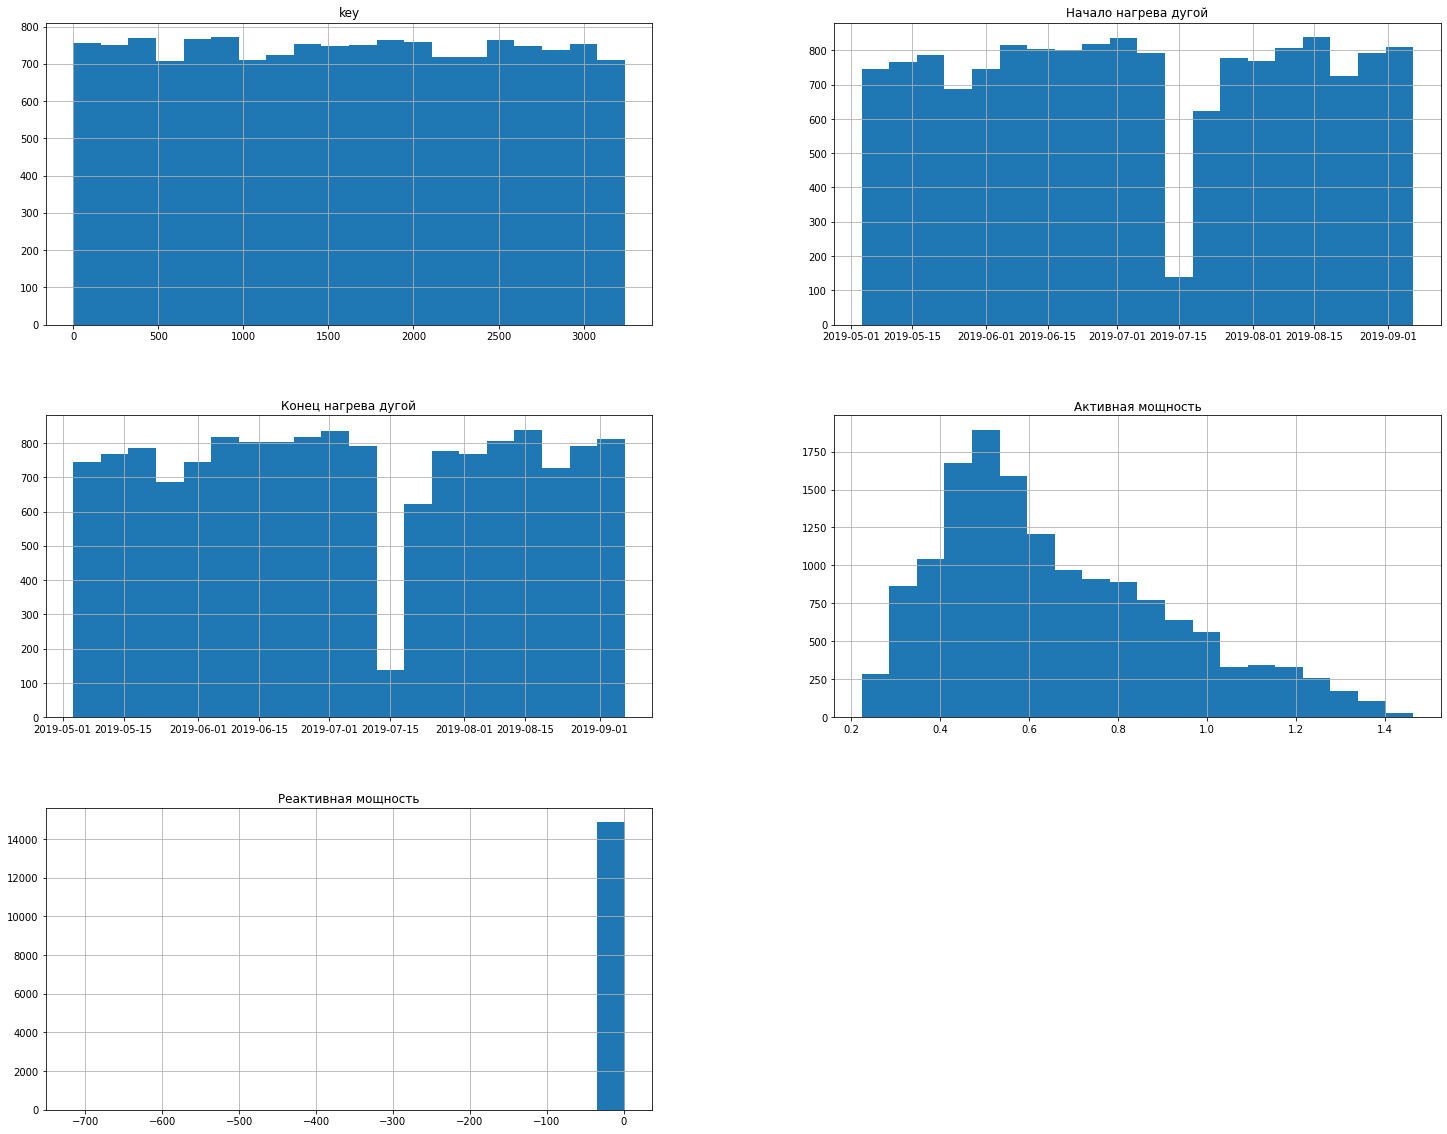

In [11]:
# построим общую гистограмму по датафрейму data_arc:

data_arc.hist(figsize=(25, 20), bins=20);


По всей видимости была приостановка производства в июле 2019 года. Возможно из-за профилактических работ, поломок, простоя или из-за особенностей работы технологического оборудования. 

Для более наглядного понимания выведем график зависимости `Начала нагрева дугой` от `Активной мощности`.

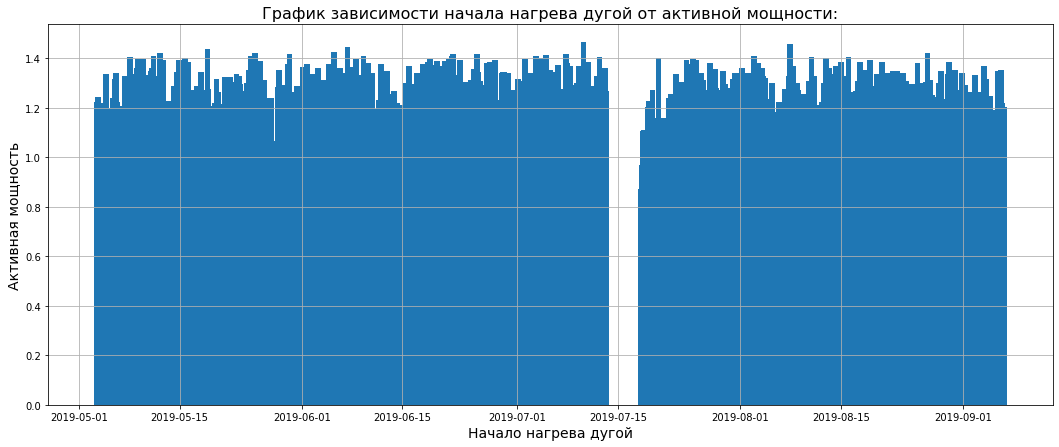

In [12]:
# график зависимости начала нагрева дугой от активной мощности:

figure, ax = plt.subplots(figsize=(18, 7))

ax.bar(data_arc['Начало нагрева дугой'], data_arc['Активная мощность'])

ax.set_title('График зависимости начала нагрева дугой от активной мощности:', fontsize=16)
ax.set_ylabel('Активная мощность', fontsize = 14)
ax.set_xlabel('Начало нагрева дугой', fontsize = 14)
ax.grid()

plt.show()

Заметно отсутствие активной мощности в середине июля 2019 года. Т.е. технологический процесс в этот период был скорее всего приостановлен.


Далее выведем аналогичный график зависимости окончания нагрева дугой от активной мощности.

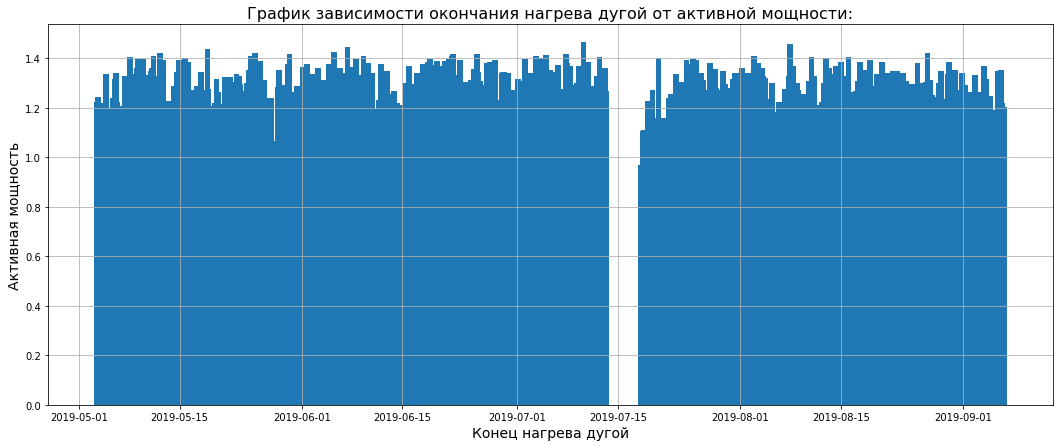

In [13]:
# график зависимости окончания нагрева дугой от активной мощности:

figure, ax = plt.subplots(figsize=(18, 7))

ax.bar(data_arc['Конец нагрева дугой'], data_arc['Активная мощность'])

ax.set_title('График зависимости окончания нагрева дугой от активной мощности:', fontsize=16)
ax.set_ylabel('Активная мощность', fontsize = 14)
ax.set_xlabel('Конец нагрева дугой', fontsize = 14)
ax.grid()

plt.show()

Далее определим более точно период останова. Для чего переведем наименования признаков на английский язык.  

In [14]:
# перевод наименования признаков на английский язык:

data_arc = data_arc.rename(columns = {
    'Начало нагрева дугой': 'start_arc',
    'Конец нагрева дугой': 'stop_arc',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'
})

In [15]:
# проверим переименование:

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_arc       14876 non-null  datetime64[ns]
 2   stop_arc        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Переименовано верно.

Выведем несколько строк датафрейма `data_arc` в период с `2019-07-13` по `2019-07-19`.

In [16]:
data_arc.query('start_arc >= "2019-07-13" and start_arc < "2019-07-19"')

,key,start_arc,stop_arc,active_power,reactive_power
8700,1892,2019-07-13 00:05:03,2019-07-13 00:09:01,0.498425,0.313185
8701,1892,2019-07-13 00:15:50,2019-07-13 00:19:23,0.374918,0.328173
8702,1892,2019-07-13 00:32:35,2019-07-13 00:34:09,0.330639,0.207321
8703,1892,2019-07-13 00:36:12,2019-07-13 00:37:50,0.977344,0.834689
8704,1892,2019-07-13 00:46:09,2019-07-13 00:46:22,0.508347,0.370268
...,...,...,...,...,...
8785,1911,2019-07-18 21:18:49,2019-07-18 21:20:53,0.549559,0.407203
8786,1912,2019-07-18 22:44:20,2019-07-18 22:46:27,0.601915,0.435264
8787,1912,2019-07-18 22:53:42,2019-07-18 22:57:49,0.374811,0.233960
8788,1912,2019-07-18 23:12:59,2019-07-18 23:15:03,0.435556,0.311296


Очевидно, что был останов в производстве с `2019-07-14` по `2019-07-17`. Для более наглядного представления построим график. Для этого сделаем промежуточный датафрейм в период с `2019-07-13` по `2019-07-19`. 

In [17]:
data_arc_start = data_arc.query('start_arc >= "2019-07-13" and start_arc <= "2019-07-19"')

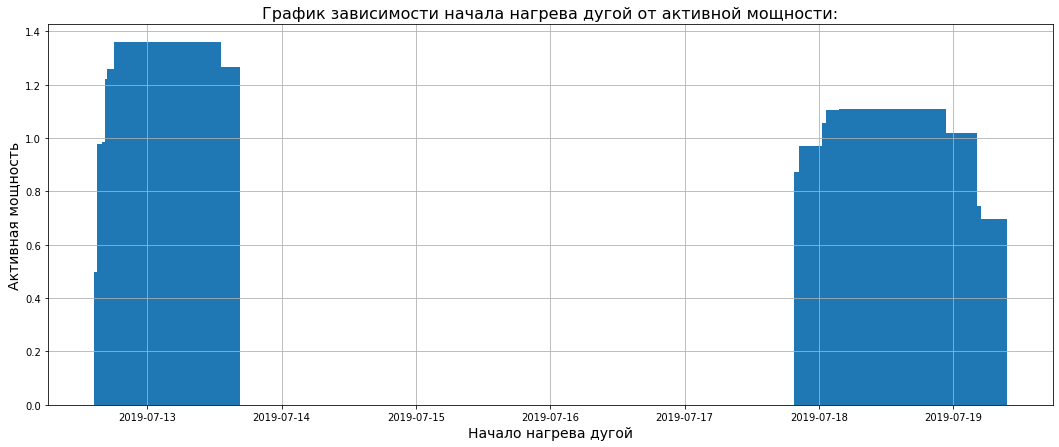

In [18]:
# график зависимости Начала нагрева дугой от Активной мощности
# в период с 2019-07-13 по 2019-07-19:

figure, ax = plt.subplots(figsize=(18, 7))

ax.bar(data_arc_start['start_arc'], data_arc_start['active_power'])

ax.set_title('График зависимости начала нагрева дугой от активной мощности:', fontsize=16)
ax.set_ylabel('Активная мощность', fontsize = 14)
ax.set_xlabel('Начало нагрева дугой', fontsize = 14)
ax.grid()

plt.show()

Наблюдаем отсутствие данных в период с `2019-07-14` по `2019-07-17` включительно (4 дня). 

Будем считать, что в эти дни было приостановлено производство. В дальнейшем нужно будет удалить все данные за этот промежуток времени.  

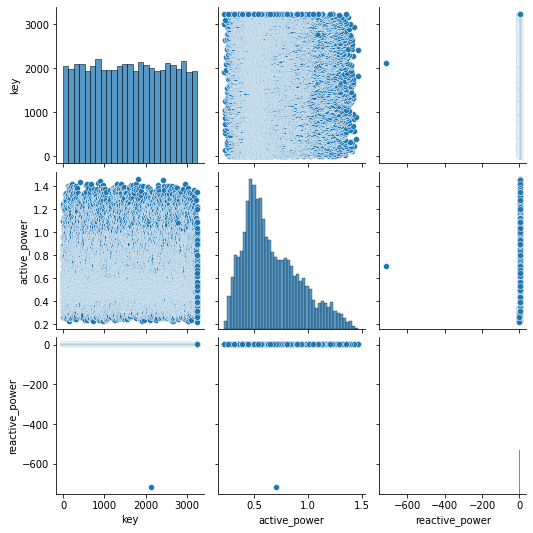

In [19]:
# построение диаграммы рассеяния по всем данным для датасета data_arc:

sns.pairplot(data_arc);

Заметно аномальное значение реактивной мощности. Удалим его. Сперва проверим сколько зафиксировано записей с отрицательной реактивной мощностью.

In [20]:
data_arc.query('reactive_power < 0')

,key,start_arc,stop_arc,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Всего одна запись. Удалим целиком партию из датафрейма.

In [21]:
# удаление партии с аномальной реактивной мощностью
# удаление по номеру ключа:
key = data_arc.query('reactive_power < 0').key

# удаление всей партии:

data_arc = data_arc[data_arc.key.isin(key) == False]

In [22]:
# проверка:

data_arc.query('reactive_power < 0')

,key,start_arc,stop_arc,active_power,reactive_power


In [23]:
# сброс индексов:

data_arc.reset_index(drop= True, inplace= True)


Удалили запись с аномальным значением реактивной мощности. Посмотрим как теперь будет выглядеть диаграмма рассеяния.

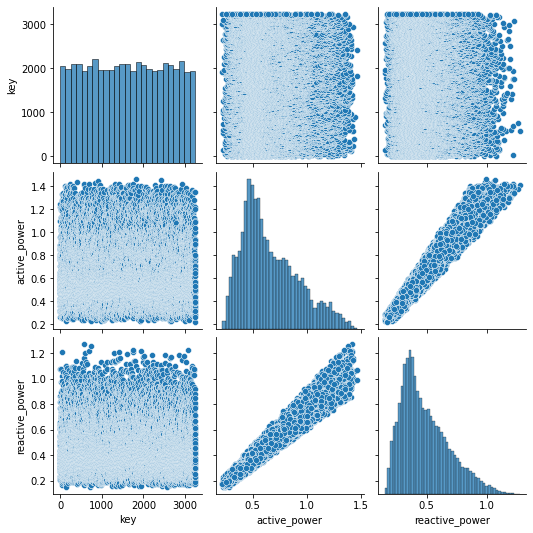

In [24]:
# построение диаграммы рассеяния по всем данным для датасета data_arc:

sns.pairplot(data_arc);

**Подытожим результат первоначального анализа датафрейма с данными об электродах (`data_arc`):**

   - в датафрейме `14876` записей;
   - предоставлены данные для `3241` партии;
   - наименование признаков было предоставлено на русском языке, для корректного выполнения запросов перевели наименования признаков на английский язык;
   - выявили и удалили аномальное значение реактивной мощности равное `-715.479924`;
   - в целом данные распределены нормально, прочих аномалий не выявлено;
   - пропуски отсутствуют;
   - явные дубликаты отсутствуют;
   - признаки `"Начало нагрева дугой"` и `"Конец нагрева дугой"` привели к типу `datetime`;
   - остальные признаки предоставлены в числовых форматах, не требующих дополнительных преобразований;
   - данные предоставлены с `2019-05-03` до `2019-09-06`;
   - с `2019-07-14` по `2019-07-17` включительно (4 дня) выявлена приостановка производства - данные за этот период должны быть удалены в дальнейшем.

**Продолжим анализ остальных датафреймов**

Для избежания повторения кода, сделаем функцию по первичному анализу датафреймов.

In [25]:
def analysis(data):
    
    display(data.describe())
    display(data.info())
    display(data.head())
    display(data.tail())
    print('Кол-во пропусков:', data.isna().sum())
    print('Кол-во явных дубликатов', data.duplicated().sum())    
    

### Изучение данных о подаче сыпучих материалов, с объемами `data_bulk`

[Назад к содержанию](#Содержание)

Согласно технологическому процессу: из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.

In [26]:
# запуск функции для первичного анализа датафрейма
# проанализируем data_bulk:

analysis(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


Кол-во пропусков: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
Кол-во явных дубликатов 0


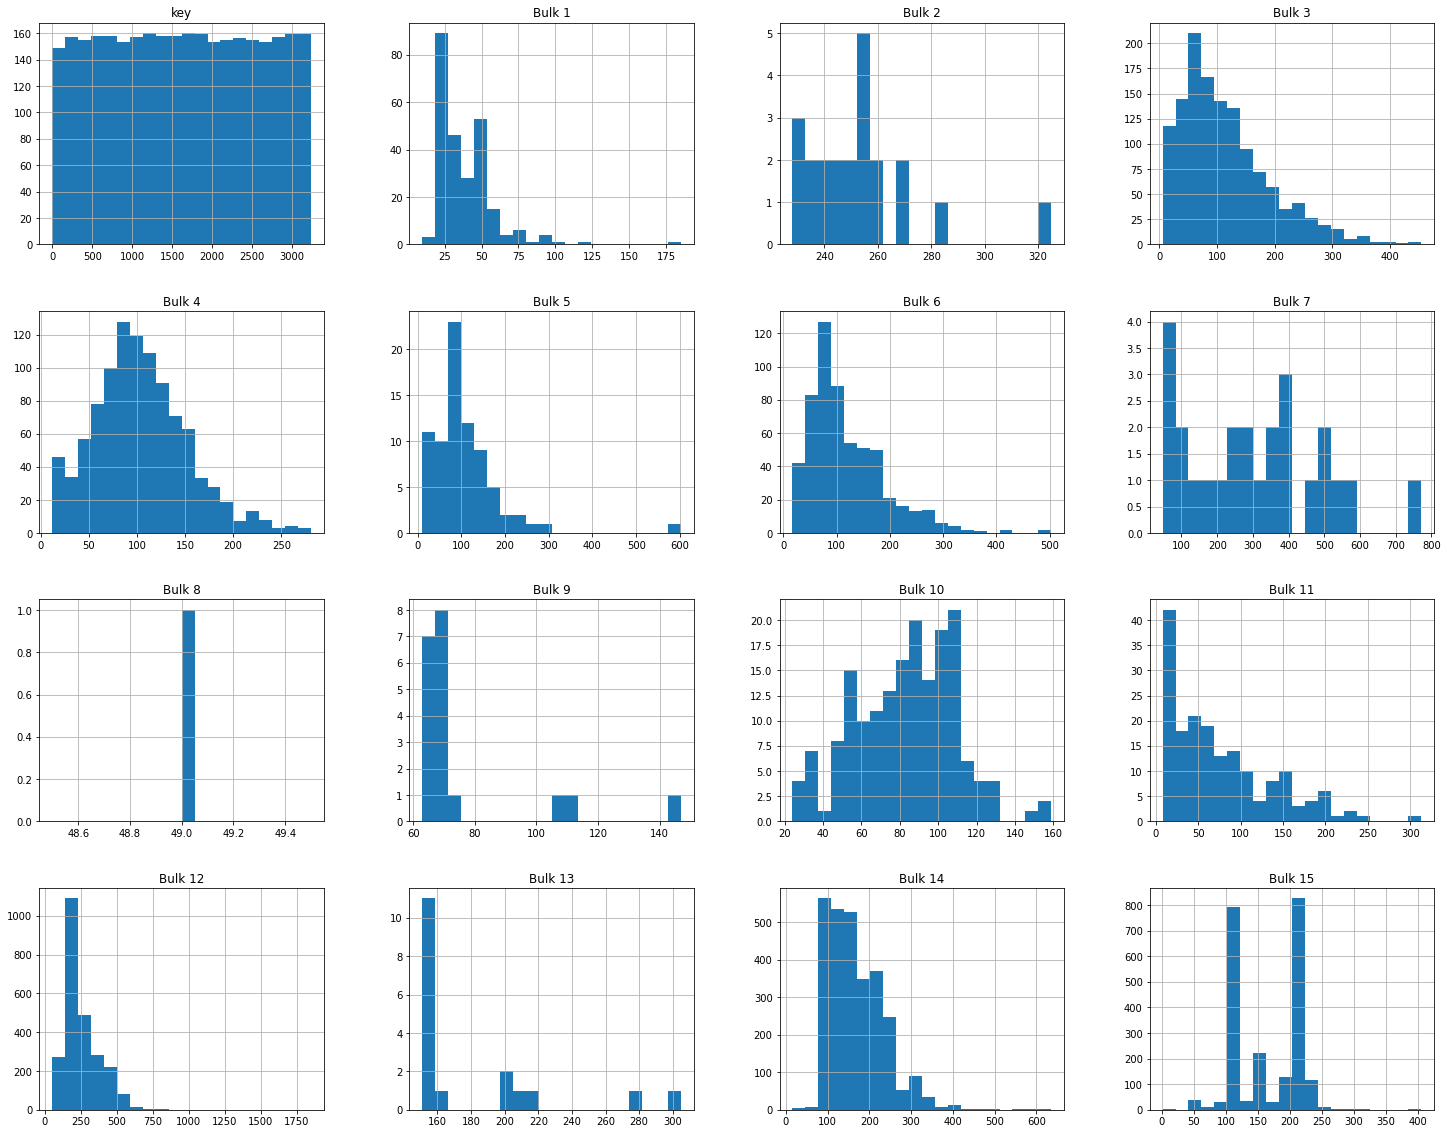

In [27]:
# построим общую гистограмму по датафрейму data_bulk:

data_bulk.hist(figsize=(25, 20), bins=20);

**На основе полученных данных о подаче сыпучих материалов (с объёмами) сделаем следующий вывод:**

   - в датафрейме `3129` записи;
   - предоставлены данные для `3241` партии;
   - данные сгруппированы по партиям;
   - похоже, что предоставлены данные не по всем партиям, поскольку записей 3129, а партий 3241;
   - предоставлены данные по подаче 15 сыпучих материалов;
   - в данных присутствуют пропуски - скорее всего это обусловлено технологическим процессом - в каждую партию допустимо добавлять не все доступные сыпучие материалы, т.к. возможно изготовление разного сорта стали;
   - пропуски удалять нельзя - заменим их в дальнейшем на `0`;
   - явные дубликаты отсутствуют;
   - признаки предоставлены в числовых форматах, не требующих дополнительных преобразований.


### Изучение данных о подаче сыпучих материалов, со временем `data_bulk_time`

[Назад к содержанию](#Содержание)

In [28]:
# запуск функции для первичного анализа датафрейма
# проанализируем data_bulk_time:

analysis(data_bulk_time)

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15


Кол-во пропусков: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
Кол-во явных дубликатов 0


Признаки предоставлены в формате `object`. Приведем к типу `datetime`.

In [29]:
# преобразование признаков к типу datetime:

for col in data_bulk_time.columns[1:]:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col])
    

In [30]:
# проверка:

data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


Преобразование выполнено верно.

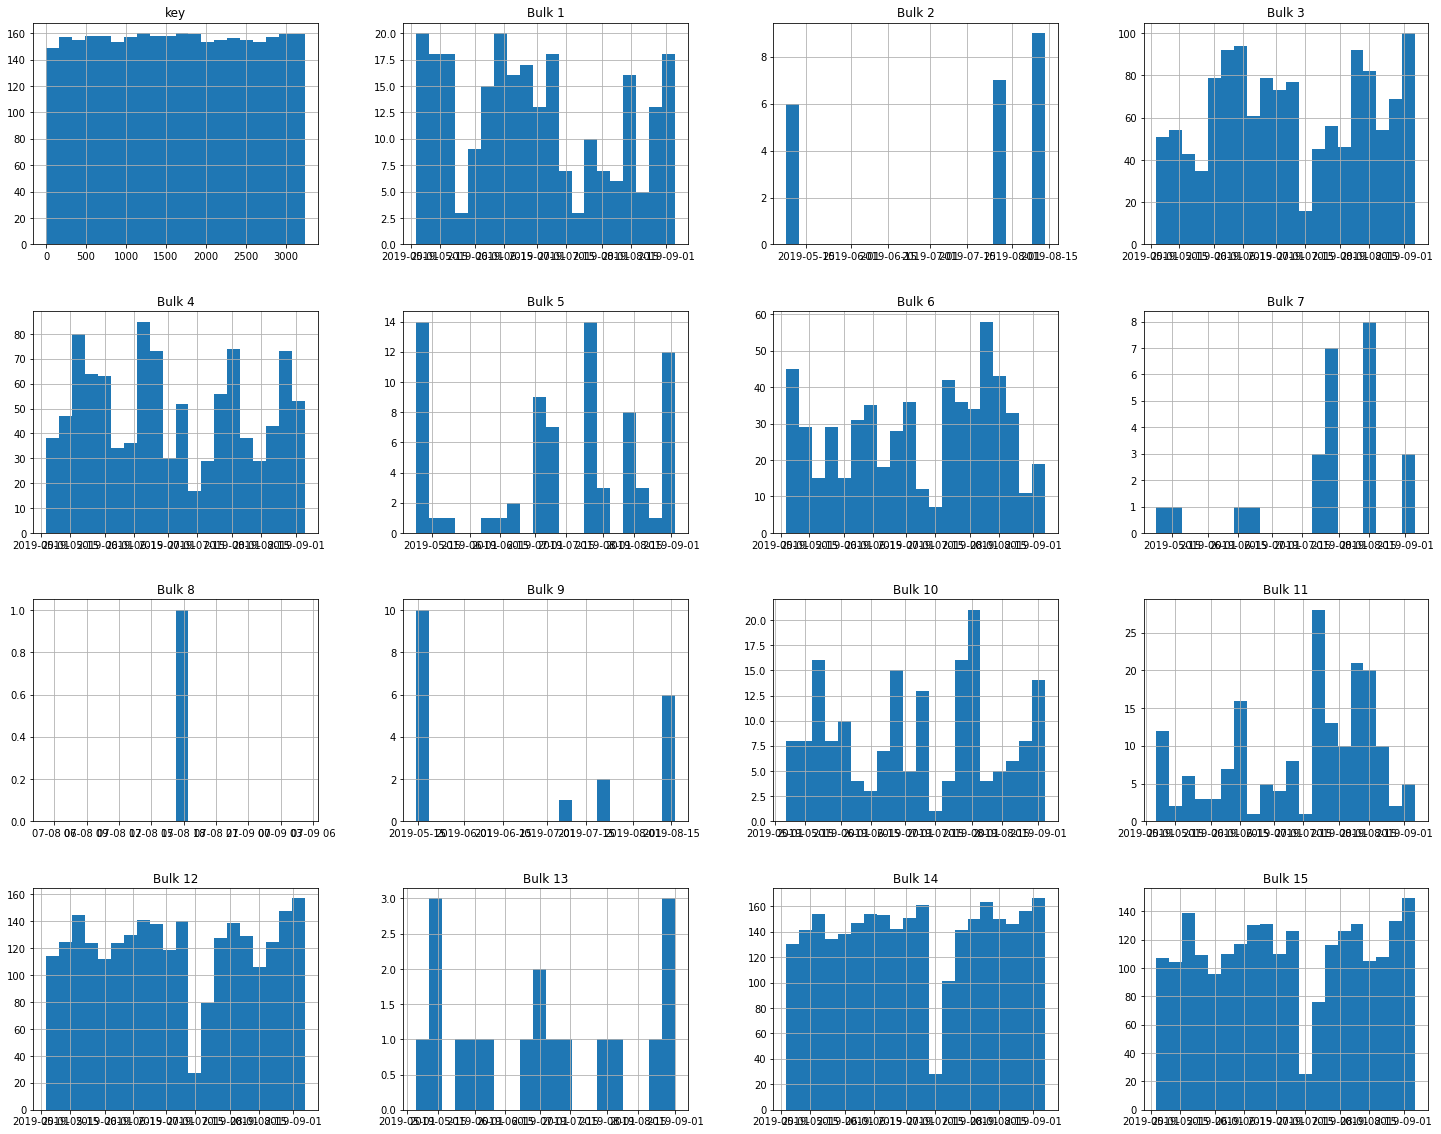

In [31]:
# построим общую гистограмму по датафрейму data_bulk_time:

data_bulk_time.hist(figsize=(25, 20), bins=20);

**На основе полученных данных о подаче сыпучих материалов (по времени) сделаем следующий вывод:**

   - в датафрейме `3129` записи;
   - предоставлены данные для `3241` партии;
   - данные сгруппированы по партиям;
   - количество данных соответствует количеству данных в датафрейме `data_bulk`;
   - предоставлены данные по времени подачи 15 сыпучих материалов;
   - присутствуют пропуски - по аналогии с объемами сыпучих материалов, заменим в дальнейшем пропуски нулём;
   - явные дубликаты отсутствуют;
   - признаки преобразовали в тип `datetime`.

### Изучение данных о продувке сплава газом `data_gas`

Согласно технологическому процессу: перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом.

[Назад к содержанию](#Содержание)

In [32]:
# запуск функции для первичного анализа датафрейма
# проанализируем data_gas:

analysis(data_gas)

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


Кол-во пропусков: key      0
Газ 1    0
dtype: int64
Кол-во явных дубликатов 0


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


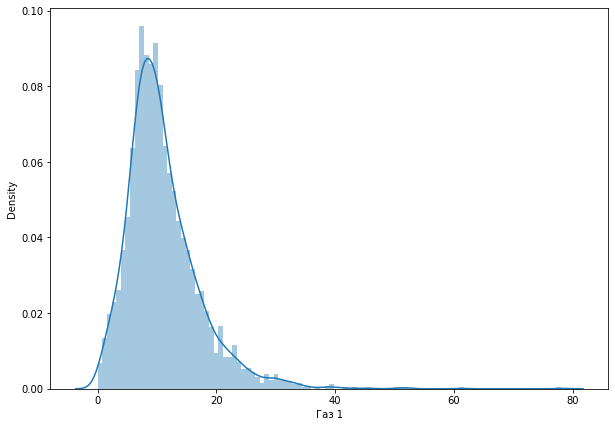

In [33]:
# построение графика распределения данных о продувке сплава газом: 

plt.figure(figsize=(10, 7))
sns.distplot(data_gas['Газ 1'], bins=100);


**На основе полученных данных о продувке сплава газом сделаем следующий вывод:**

   - в датафрейме `3239` записи;
   - предоставлены данные для `3241` партии;
   - данные сгруппированы по партиям;
   - пропуски отсутствуют;
   - явные дубликаты отсутствуют;
   - ярко выраженных аномальных значений не выявлено;
   - наименование признака приведено на русском языке, что вполне может в дальнейшем потребовать преобразования на английский язык.

### Изучение результатов измерения температуры `data_temp`

[Назад к содержанию](#Содержание)

In [34]:
# запуск функции для первичного анализа датафрейма
# проанализируем data_temp:

analysis(data_temp)

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Время замера,Температура
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


Кол-во пропусков: key                0
Время замера       0
Температура     3427
dtype: int64
Кол-во явных дубликатов 0


Обнаружена минимальная температура замера `1191`. Минимальная температура плавления стали составляет порядка `1500` градусам по Цельсию. Возможно это связано с поломкой или погрешностью датчиков. Для нас это аномальное значение. Поэтому все замеры с температурой менее `1500` градусам рассматриваем как выбросы и все партии с такими замерами подлежат удалению.

Подсчитаем количество замеров с температурой менее `1500`.

In [35]:
data_temp.query('Температура < 1500').count()

key             5
Время замера    5
Температура     5
dtype: int64

Всего 5 записей. Выведем их.

In [36]:
data_temp.query('Температура < 1500')

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Удалим целиком все партии, в которых температура хотя бы одного замера менее `1500`. Удаление выполним по номеру партии.

In [37]:
# список номеров партий, в которых температура менее 1500:
keys = data_temp.query('Температура < 1500').key

# удаление партий, в которых температура менее 1500:
data_temp = data_temp[data_temp.key.isin(keys) == False]

# проверка наличия температур < 1500:
print('Кол-во записей с температурой < 1500:')
print(data_temp.query('Температура < 1500').count())
print()

# проверка наличия партий keys:
print('Кол-во записей с партиями, где темература < 1500:')
data_temp.loc[data_temp['key'].isin(keys)].count()


Кол-во записей с температурой < 1500:
key             0
Время замера    0
Температура     0
dtype: int64

Кол-во записей с партиями, где темература < 1500:


key             0
Время замера    0
Температура     0
dtype: int64

In [38]:
# сброс индексов:

data_temp.reset_index(drop= True, inplace= True)

In [39]:
# вывод первых строк для проверки:

data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [40]:
# вывод последних строк для проверки:

data_temp.tail()

,key,Время замера,Температура
18060,3241,2019-09-06 16:55:01,NaN
18061,3241,2019-09-06 17:06:38,NaN
18062,3241,2019-09-06 17:21:48,NaN
18063,3241,2019-09-06 17:24:44,NaN
18064,3241,2019-09-06 17:30:05,NaN


Удалили все партии, в которых были зафиксированы замеры менее `1500` градусов.

Далее приведем признак время замера к типу `datetime`.

In [41]:
# преобразование признака "Время замера" к типу datetime:

data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [42]:
# проверка:

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18065 entries, 0 to 18064
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18065 non-null  int64         
 1   Время замера  18065 non-null  datetime64[ns]
 2   Температура   14643 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 423.5 KB


Преобразование выполнено верно.

Для более наглядного понимания результатов измерения температуры выведем график зависимости времени замера и температуры.

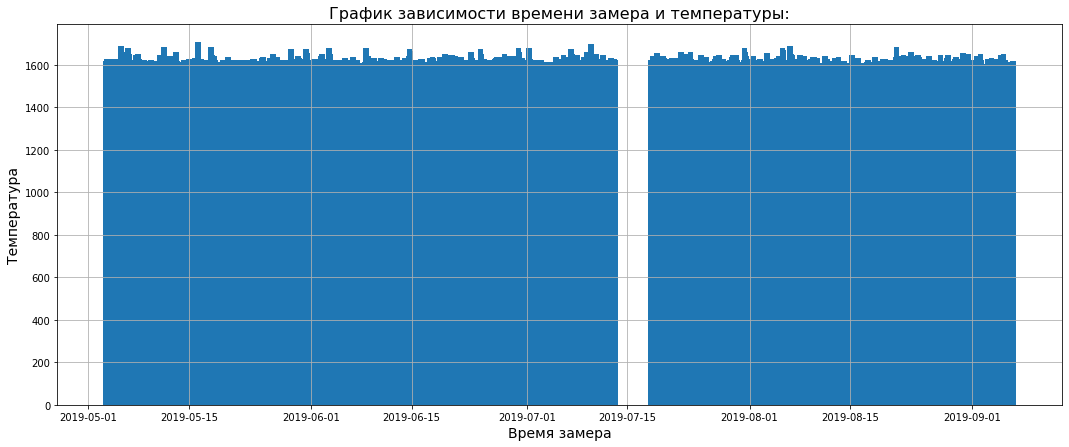

In [43]:
# график зависимости времени замера и температуры:

figure, ax = plt.subplots(figsize=(18, 7))

ax.bar(data_temp['Время замера'], data_temp['Температура'])

ax.set_title('График зависимости времени замера и температуры:', fontsize=16)
ax.set_ylabel('Температура', fontsize = 14)
ax.set_xlabel('Время замера', fontsize = 14)
ax.grid()

plt.show()

Еще раз выявлена приостановка производства в течении нескольких дней в середине июля 2019 года. Выявим точные даты приостановки производства - они должны быть такие же как и в датафрейме с данными об электродах.

Сперва приведем наименования признаков на английский язык.

In [44]:
# перевод наименования признаков на английский язык:

data_temp = data_temp.rename(columns = {
    'Время замера': 'temp_time',
    'Температура': 'temperature'
})

In [45]:
# проверим:

data_temp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18065 entries, 0 to 18064
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          18065 non-null  int64         
 1   temp_time    18065 non-null  datetime64[ns]
 2   temperature  14643 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 423.5 KB


Переименовано верно.

Выведем несколько строк датафрейма в период с 2019-07-13 по 2019-07-19.

In [46]:
data_temp.query('temp_time >= "2019-07-13" and temp_time < "2019-07-19"')

,key,temp_time,temperature
10562,1892,2019-07-13 00:04:53,1596.0
10563,1892,2019-07-13 00:15:40,1591.0
10564,1892,2019-07-13 00:32:25,1598.0
10565,1892,2019-07-13 00:36:02,1596.0
10566,1892,2019-07-13 00:45:59,1599.0
...,...,...,...
10668,1912,2019-07-18 22:44:10,1628.0
10669,1912,2019-07-18 22:53:32,1629.0
10670,1912,2019-07-18 23:12:49,1629.0
10671,1912,2019-07-18 23:26:15,1592.0


Предположение подтвердилось - действительно была остановка производства с `2019-07-14` по `2019-07-17`.

**На основе результатов измерения температуры сделаем следующий вывод:**

   - в датафрейме `18092` записи;
   - предоставлены данные для `3241` партии;
   - данные предоставлены по партиям, как и в датафрейме об электродах;
   - присутствуют пропуски в признаке Температура - возможно не было замеров, в дальнейшем заменим пропуски на `0`;
   - выявлены аномальные значения температуры стали - менее `1500` градусов по Цельсию. Всего было зафиксировано 5 записей с температурой ниже `1500`. Все эти записи были удалены;
   - явные дубликаты отсутствуют;
   - признак 'Время замера' приведен к типу `datetime`;
   - наименование признаков переведено на английский язык;
   - по всей видимости должна быть линейная зависимость между расходуемой мощностью на нагрев электродов и температурой: чем больше тратится энергии на нагрев электродов, тем более высокая температура должна быть зафиксирована;
   - еще раз выявлена приостановка производства с `2019-07-13` по `2019-07-19`.

### Изучение данных о проволочных материалах, с объёмами `data_wire`

[Назад к содержанию](#Содержание)

In [47]:
# запуск функции для первичного анализа датафрейма
# проанализируем data_wire:

analysis(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Кол-во пропусков: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
Кол-во явных дубликатов 0


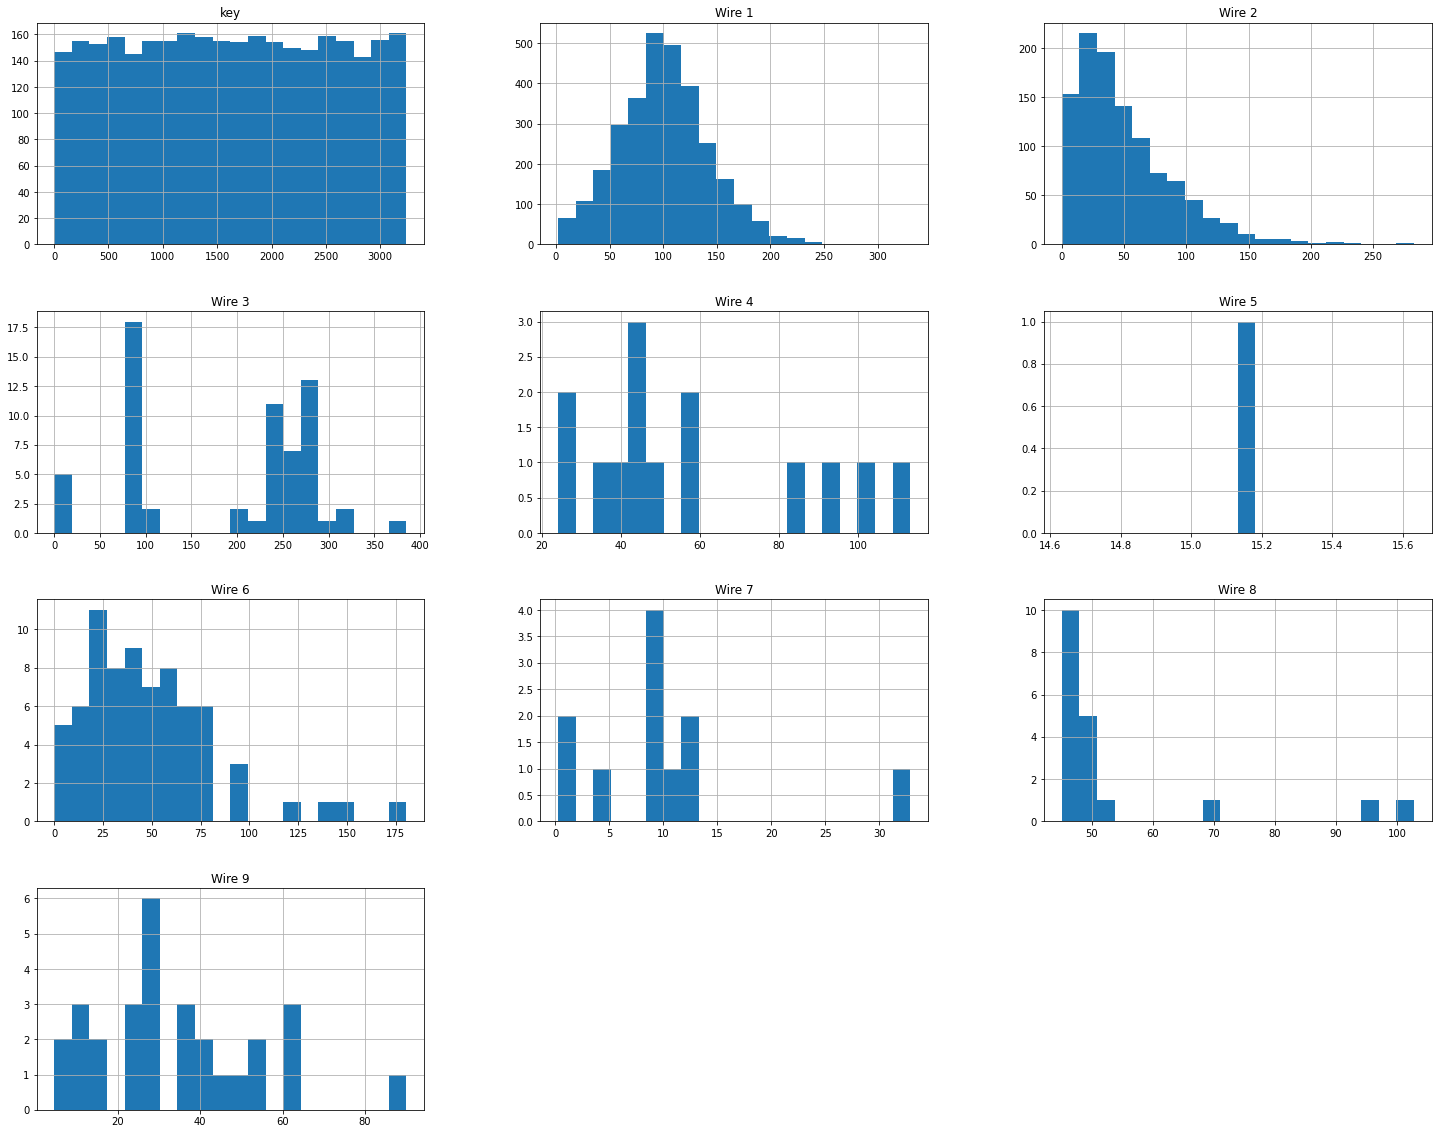

In [48]:
# построим общую гистограмму по датафрейму data_wire:

data_wire.hist(figsize=(25, 20), bins=20);

**На основе полученных данных о проволочных материалах с объемами сделаем следующий вывод:**

   - в датафрейме `3081` запись;
   - данные сгруппированы по партиям;
   - предоставлены данные по `9` проволочным материалам с объемами;
   - в данных присутствуют пропуски - скорее всего это обусловлено технологическим процессом - не все проволочные материалы требуется добавлять в каждой партии, поэтому заменим в дальнейшем пропуски нулем;
   - явные дубликаты отсутствуют;
   - ярко выраженных аномальных значений не выявлено.

### Изучение данных о проволочных материалах, со временем `data_wire_time`

[Назад к содержанию](#Содержание)

In [49]:
# запуск функции для первичного анализа датафрейма
# проанализируем data_wire_time:

analysis(data_wire_time)

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Кол-во пропусков: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
Кол-во явных дубликатов 0


Признаки предоставлены в формате `object`. Приведем к типу `datetime`.

In [50]:
# преобразование признаков к типу datetime:

for col in data_wire_time.columns[1:]:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col])
    

In [51]:
# проверка:

data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Преобразования выполнены верно.

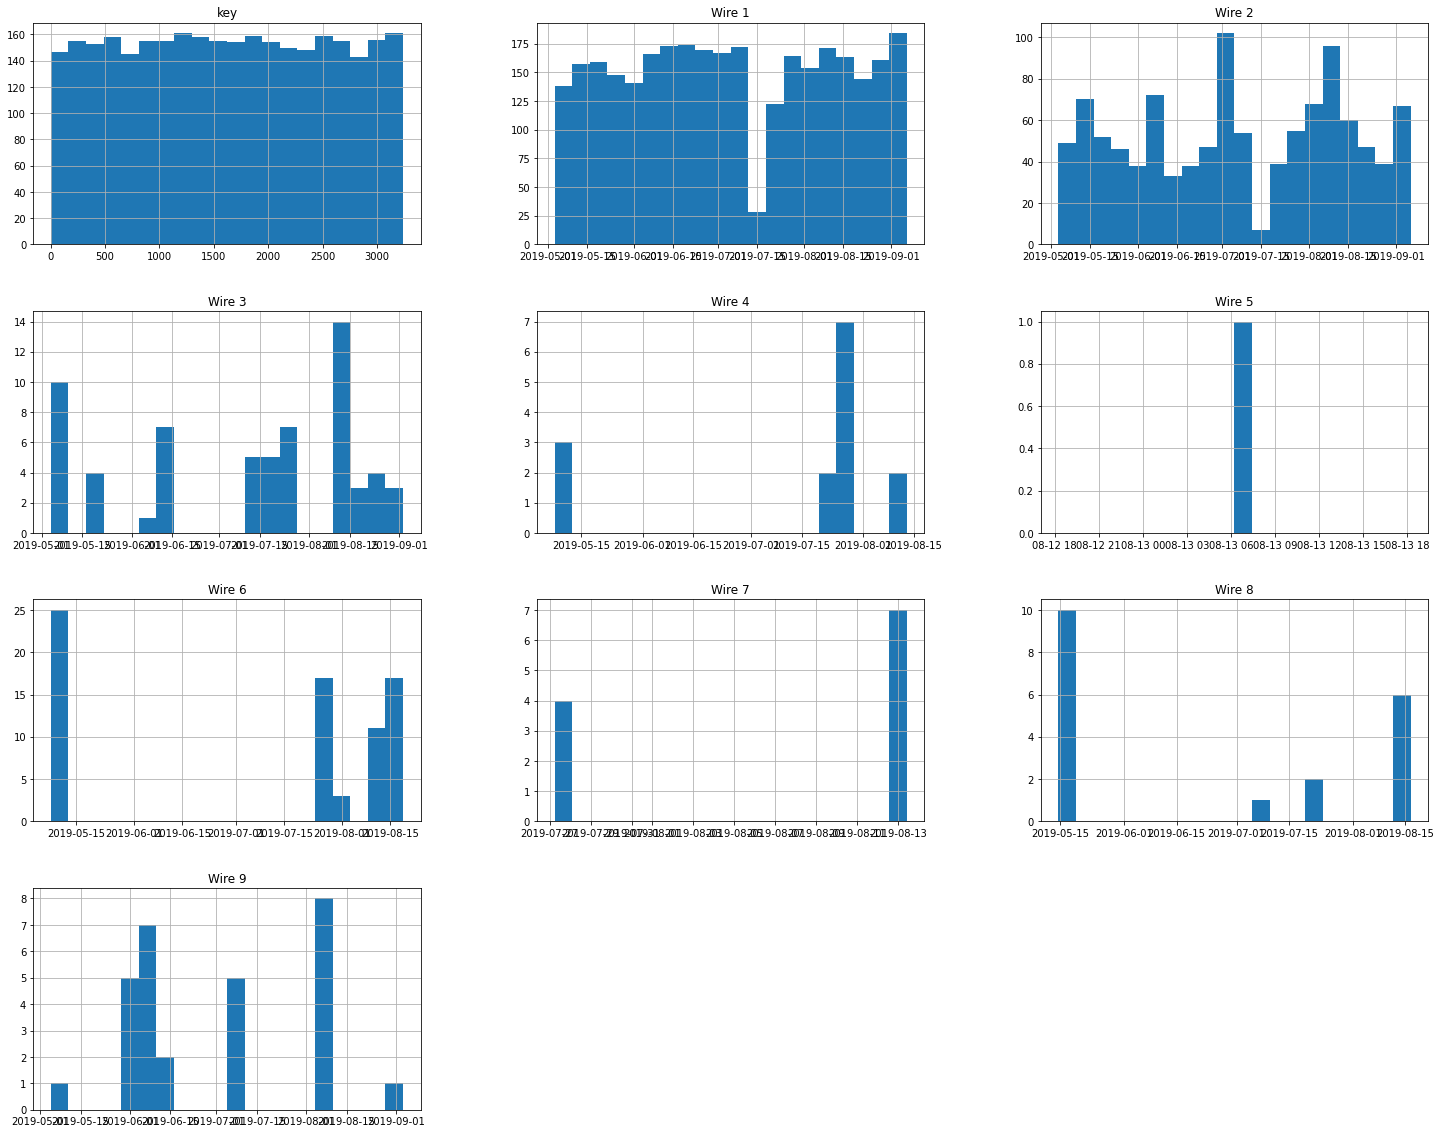

In [52]:
# построим общую гистограмму по датафрейму data_wire_time:

data_wire_time.hist(figsize=(25, 20), bins=20);

**На основе полученных данных о проволочных материалах (по времени) сделаем следующий вывод:**

   - в датафрейме `3081` запись;
   - предоставлены данные для `3241` партии;
   - данные сгруппированы по партиям;
   - количество данных соответствует количеству данных в датафрейме `data_wire`;
   - предоставлены данные по `9` проволочным материалам с объемами;
   - присутствуют пропуски, что соответствует датафрейму с объемами проволочных материалов - заменим в дальнейшем пропуски нулем;
   - явные дубликаты отсутствуют;
   - признаки преобразовали в тип `datetime`.

### Выводы об исследовательском анализе данных

[Назад к содержанию](#Содержание)

В ходе исследовательского анализа данных было загружено и изучено 7 датасетов с данными:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

В целом во всех датасетах приведены данные для `3241` партии. Ярко-выраженных аномальных значений нет, данные распределены нормально. Встретились две аномалии: 

   - в данных об электродах была зафиксирована минимальная реактивная мощность `-715.479924`;
   - в данных о результатах измерения температуры были зафиксированы значения менее `1500` градусов по Цельсию, что менее температуры плавления стали.
   
Выявленные на данном этапе записи с аномальными значениями были удалены из датафреймов. Пропуски в данных о подаче материалов связаны с технологическим процессом производства стали и будут заменены нулем на следующей стадии проекта.

1. Данные об электродах:

   - выявили и удалили аномальное значение реактивной мощности равное `-715.479924`;
   - в целом данные распределены нормально, прочих аномалий не выявлено;
   - пропуски отсутствуют;
   - явные дубликаты отсутствуют;
   - признаки "Начало нагрева дугой" и "Конец нагрева дугой" привели к типу `datetime`;
   - остальные признаки предоставлены в числовых форматах, не требующих дополнительных преобразований;
   - данные предоставлены с `2019-05-03` до `2019-09-06`;
   - с `2019-07-14` по `2019-07-17` включительно (4 дня) выявлена приостановка производства.
   
   
2. Данные о подаче сыпучих материалов (объём):

   - предоставлены данные по подаче 15 сыпучих материалов;
   - в данных присутствуют пропуски - скорее всего это обусловлено технологическим процессом - вероятнее всего, что в каждую партию нет необходимости добавлять абсолютно все доступные сыпучие материалы. Удалять эти пропуски нельзя. В дальнейшем произведем замену пропусков на 0;
   - явные дубликаты отсутствуют;
   - признаки предоставлены в числовых форматах, не требующих дополнительных преобразований.
   
   
3. Данные о подаче сыпучих материалов (время):

   - количество данных соответствует количеству данных в датафрейме с объемами сыпучих материалов;
   - предоставлены данные по времени подачи 15 сыпучих материалов;
   - присутствуют пропуски - по аналогии с объемами сыпучих материалов, заменим в дальнейшем пропуски нулем;
   - аномальные значения не выявлены;
   - явные дубликаты отсутствуют;
   - признаки преобразовали в тип `datetime`.

    
4. Данные о продувке сплава газом:

   - пропуски отсутствуют;
   - явные дубликаты отсутствуют;
   - ярко выраженных аномальных значений не выявлено;
   - наименование признака приведено на русском языке, что вполне может в дальнейшем потребовать преобразования на английский язык.
 
   
5. Результаты измерения температуры:

   - выявлены аномальные значения температуры стали - `менее 1500` градусов по Цельсию. Всего было зафиксировано 5 записей с температурой ниже `1500`. Все эти записи были удалены;
   - явные дубликаты отсутствуют;
   - данные предоставлены по партиям, как и в датафрейме об электродах;
   - присутствуют пропуски в признаке Температура - возможно не было замеров, в дальнейшем заменим пропуски на 0;
   - явные дубликаты отсутствуют;
   - признак 'Время замера' приведен к типу `datetime`;
   - наименование признаков переведено на английский язык;
   - еще раз выявлена приостановка производства с 2019-07-13 по 2019-07-19.
   
   
6. Данные о проволочных материалах (объём):

   - предоставлены данные по 9 проволочным материалам с объемами;
   - в данных присутствуют пропуски - скорее всего это обусловлено технологическим процессом - не все проволочные материалы требуется добавлять в каждой партии, поэтому заменим в дальнейшем пропуски нулем;
   - явные дубликаты отсутствуют;
   - ярко выраженных аномальных значений не выявлено
   
   
7. Данные о проволочных материалах (время):

   - количество данных соответствует количеству данных в датафрейме с объемом проволочных материалов;
   - предоставлены данные по 9 проволочным материалам с объемами;
   - присутствуют пропуски, что соответствует датафрейму с объемами проволочных материалов - заменим в дальнейшем пропуски нулем;
   - явные дубликаты отсутствуют;
   - признаки преобразовали в тип datetime.

На этом завершаем исследовательский анализ и переходим к следующему этапу проектной работы.

## Составление плана

[Назад к содержанию](#Содержание)

Приведем план работы, согласно которому будем придерживаться при решении поставленной задачи.

**3. "Разработка модели"**. Данный пункт будет содержать следующие этапы: 

1. Обработка данных

1.1 На этапе анализа данных были выявлены пропуски в данных. Пропуски не означают выбросы или аномалии, а означают отсутствие добавления тех или иных компонентов в процессе производства. Поэтому данные эти нужны. Пропуски заменим нулем.

1.2 В датафреймах остались признаки на русском языке. Вполне возможно потребуется перевод на английский наименований таких признаков для корректной отработки кода.

1.3 Проверить датафреймы с данными об электродах и с результатами измерения температуры на наличие единичного замера в партии. В партии не может быть одного замера, поэтому все партии с единичными замерами должны быть исключены.

1.4 Проанализировать данные о сыпучих материалах и о проволочных материалах (с объемом и временем). Эти данные не требуются для обучения модели. Проверить данные на предмет корректности полученных данных от заказчика.

1.4 Возможно будет полезным выполнить замену реактивной и активной энергии на полную мощность. Также можно ввести новый признак - работа  - это полная мощность, умноженная на время. 

2. Объединение датафреймов

2.1. Для обучения модели потребуется объединить все датафреймы в один. Объединить нужно только те датафреймы, которые потребуются для обучения моделей. В качестве ключа будем использовать номер партии.

2.2 После объединения датафреймов в один необходимо вывести графики распределения признаков и тепловую карту корреляционной зависимости. На основе полученных данных принять решение и удалить один признак из пары признаков в случае высокой корреляционной зависимости между признаками. Изучить важность признаков. Допускается исключить признаки с малой долей важности. Это позволит ускорить процесс обучения моделей

2.3 Выполнить анализ объединенного датафрейма на предмет аномальных значений, выбросов и масштаба принимаемых значений. Выполнить масштабирование признаков.

3. Обучение моделей

3.2 Подготовка обучающей и тестовой выборок. Разделим данные в следующем соотношении: 80% под обучающую выборку, 20% под тестовую выборку.

3.1 Поскольку у нас задача регрессии, для ее решения будем обучать несколько моделей. С задачами регрессии хорошо справляются модели, обученные с помощью градиентного бустинга. Поэтому используем `LGBM`, `CatBoost` и `Ridge`. Также стоит проверить модели из библиотеки `sklearn`: `линейную регрессию` и `случайный лес в регрессии`. Иногда простые модели дают наилучший результат. 

В качестве функции минимизации будем использовать `MAE` - среднюю абсолютною ошибку. Согласно техническому заданию на разработку модели `MAE` должна быть не более `6.8`.

Поиск оптимальных гиперпараметров выполним с помощью `RandomizedSearchCV`. Выбран `RandomizedSearchCV`, т.к. он быстрее работает по сравнению с `GridSearchCV` (хотя вполне возможно ухудшение качества модели).

3.2 Выбор наилучшей модели из обученных.

3.3 Сравнение наилучшей модели с `dummy-моделью`.

3.4 Тестирование наилучшей модели на тестовой выборке.

3.5 Исследование важности признаков наилучшей модели.


**4. Отчет**

В отчете будут выполнены следующие этапы:


4.1 Сравнение решения и разработанного плана с указанием причин, по которым не были выполнены конкретные шаги.

4.2 Описание трудностей проекта и их решения.

4.3 Перечисление всех признаков, используемых для обучения моделей. Описание предобработки данных.

4.4 Описание модели

4.5 Вывод итоговой метрики на тестовой выборке.

## Разработка модели

[Назад к содержанию](#Содержание)

### Обработка данных

#### Обработка пропусков

На этапе анализа данных были выявлены пропуски в данных. Пропуски были выявлены в данных о подаче сыпучих материалов (с объемом и временем), в результатах измерения температуры, а также в данных о проволочных материалах (с объемом и временем).

Пропуски не означают выбросы или аномалии, а означают отсутствие добавления тех или иных компонентов в процессе производства. Также означают отсутствие замеров температуры. Поэтому данные эти нужны. Пропуски заменим нулем.

Поочередно будем выводить датафреймы с пропусками, кратко анализировать и делать замены.

**1. Данные о подаче сыпучих материалов (объём)**

[Назад к содержанию](#Содержание)

Выведем общую информацию:

In [53]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Присутствуют материалы, которые добавляли совсем немного раз. Это следующие материалы:

   - Bulk 2;
   - Bulk 7;
   - Bulk 8;
   - Bulk 9;
   - Bulk 13
   
Вполне возможно, что это редкие материалы. Их добавление необходимо для достижения требуемого качества металла. Поэтому оставим данные без изменений.

In [60]:
# подсчет количества пропусков:

data_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [61]:
# замена NaN на ноль во всем датафрейме:
data_bulk = data_bulk.fillna(0)

# проверка на пропуски:
data_bulk.isna().sum()

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

Заменили все `NaN` на нулевые значения.

Чтобы не повторять код для остальных датафреймов с пропусками, сделаем функцию `analysis_nan` по анализу и замене пропусков.

In [62]:
# функция по анализу и замене NaN нулем:

def analysis_nan(data):
    print('Количество пропусков:')
    display(data.isna().sum())
    print('Первые 5 строк с NaN:')
    display(data[data.isna().any(1)].head())
    print('Последние 5 строк с NaN:')
    display(data[data.isna().any(1)].tail())
    data = data.fillna(0)
    print('Количество пропусков после замен нулем:')
    display(data.isna().sum())
    print('Вывод первых 5 строк после произведенных замен:')
    display(data.head())
    print('Вывод последних 5 строк после произведенных замен:')
    display(data.tail())
    return data

**2. Данные о подаче сыпучих материалов (время)**

[Назад к содержанию](#Содержание)

In [63]:
# вызов функции по анализу и замене пропусков нулем:

data_bulk_time = analysis_nan(data_bulk_time)

Количество пропусков:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Первые 5 строк с NaN:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


Последние 5 строк с NaN:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaT,NaT,2019-09-06 11:54:15,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 11:49:45,NaT,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaT,NaT,2019-09-06 12:26:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 12:18:35,NaT,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:06:00,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:01:44,NaT,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:24:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 17:26:33,2019-09-06 17:23:15


Количество пропусков после замен нулем:


key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

Вывод первых 5 строк после произведенных замен:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


Вывод последних 5 строк после произведенных замен:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,0,0,2019-09-06 11:54:15,0,0,0,0,0,0,0,0,2019-09-06 11:49:45,0,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,0,0,2019-09-06 12:26:52,0,0,0,0,0,0,0,0,2019-09-06 12:18:35,0,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,0,0,0,0,0,2019-09-06 15:06:00,0,0,0,0,0,2019-09-06 15:01:44,0,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,0,0,0,0,0,2019-09-06 16:24:28,0,0,0,0,0,0,0,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-09-06 17:26:33,2019-09-06 17:23:15


Заменили все `NaN` на нулевые значения. Переходим к следующей таблице.

**3. Результаты измерения температуры**

[Назад к содержанию](#Содержание)

In [64]:
# вызов функции по анализу и замене пропусков нулем:

data_temp = analysis_nan(data_temp)

Количество пропусков:


key               0
temp_time         0
temperature    3422
dtype: int64

Первые 5 строк с NaN:


,key,temp_time,temperature
13906,2500,2019-08-10 14:13:11,NaN
13907,2500,2019-08-10 14:18:12,NaN
13908,2500,2019-08-10 14:25:53,NaN
13909,2500,2019-08-10 14:29:39,NaN
13911,2501,2019-08-10 14:49:15,NaN


Последние 5 строк с NaN:


,key,temp_time,temperature
18060,3241,2019-09-06 16:55:01,NaN
18061,3241,2019-09-06 17:06:38,NaN
18062,3241,2019-09-06 17:21:48,NaN
18063,3241,2019-09-06 17:24:44,NaN
18064,3241,2019-09-06 17:30:05,NaN


Количество пропусков после замен нулем:


key            0
temp_time      0
temperature    0
dtype: int64

Вывод первых 5 строк после произведенных замен:


,key,temp_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Вывод последних 5 строк после произведенных замен:


,key,temp_time,temperature
18060,3241,2019-09-06 16:55:01,0.0
18061,3241,2019-09-06 17:06:38,0.0
18062,3241,2019-09-06 17:21:48,0.0
18063,3241,2019-09-06 17:24:44,0.0
18064,3241,2019-09-06 17:30:05,0.0


В данных с результатами измерения температуры было `3422` пропусков, которые мы заменили нулем. Посмотрим одну партию, в которой хотя бы один замер равен нулю.

In [65]:
# одна партия, в которой замер температуры равен нулю:

data_temp.query('key == 2500')


,key,temp_time,temperature
13905,2500,2019-08-10 14:04:39,1539.0
13906,2500,2019-08-10 14:13:11,0.0
13907,2500,2019-08-10 14:18:12,0.0
13908,2500,2019-08-10 14:25:53,0.0
13909,2500,2019-08-10 14:29:39,0.0


Итак, в этой партии присутствует только результат измерения температуры первого этапа. Такой этап нас не устроит, т.к. мы должны предсказать последнюю температуру по каждому этапу. В качестве обучающего значения мы будем использовать только первую температуру. Промежуточные значения нас не интересуют. 

В связи с этим сделаем следующий вывод о том, что необходимо исключить из датасета все партии, в которых встретилась нулевая первичная или конечная температура. Будем считать такие партии не пригодными для обучения модели.

**4. Данные о проволочных материалах (объём)**

[Назад к содержанию](#Содержание)

Выведем общую информацию:

In [66]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Присутствуют материалы, которые добавляли совсем мало. Оставим их без изменений.

Удалим признак `Wire 5`, т.к. его засыпали лишь один раз и для обучения он не сильно поможет, а скорее наоборот.

In [74]:
# удаление Wire 5, т.к. его засыпали лишь один раз:

data_wire.drop('Wire 5', axis=1, inplace=True)

In [75]:
# вывод общей информации:

data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 6  73 non-null     float64
 6   Wire 7  11 non-null     float64
 7   Wire 8  19 non-null     float64
 8   Wire 9  29 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 216.8 KB


In [76]:
# вызов функции по анализу и замене пропусков нулем:

data_wire = analysis_nan(data_wire)

Количество пропусков:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Первые 5 строк с NaN:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN


Последние 5 строк с NaN:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество пропусков после замен нулем:


key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

Вывод первых 5 строк после произведенных замен:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


Вывод последних 5 строк после произведенных замен:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3080,3241,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Заменили все `NaN` на нулевые значения. Переходим к следующей таблице.

**5. Данные о проволочных материалах (время)**

[Назад к содержанию](#Содержание)

In [77]:
# проверка по первым строкам:

data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [78]:
# вызов функции по анализу и замене пропусков нулем:

data_wire_time = analysis_nan(data_wire_time)


Количество пропусков:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Первые 5 строк с NaN:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Последние 5 строк с NaN:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3080,3241,2019-09-06 17:10:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Количество пропусков после замен нулем:


key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

Вывод первых 5 строк после произведенных замен:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:36:50,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:11:46,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:43:22,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0,0


Вывод последних 5 строк после произведенных замен:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-09-06 11:33:38,0,0,0,0,0,0,0,0
3077,3238,2019-09-06 12:18:35,0,0,0,0,0,0,0,0
3078,3239,2019-09-06 14:36:11,0,0,0,0,0,0,0,0
3079,3240,2019-09-06 15:33:55,0,0,0,0,0,0,0,0
3080,3241,2019-09-06 17:10:06,0,0,0,0,0,0,0,0


Заменили все `NaN` на нулевые значения.

На этом мы завершили замену пропусков нулем во всех датафреймах.

#### Перевод наименований признаков на английский язык

[Назад к содержанию](#Содержание)

На этапе исследовательского анализа данных наименования некоторых признаков перевели на английский язык. Тем не менее, где-то остались русские наименованиями признаков. На русском языке код запроса может сломаться, поэтому приведем наименования к английскому языку. 

У нас остался только один датафрейм с русскими наименованиями признаков - это датафрейм с данными о продувке сплава газом.

In [79]:
# вывод общей информации:

data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [80]:
# перевод наименования признака на английский язык:

data_gas = data_gas.rename(columns = {
    'Газ 1': 'gas_1'
})

In [81]:
# проверка:

data_gas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Итак, в настоящий момент у нас все датафреймы с английскими наименованиями признаков.

#### Анализ данных об электродах

[Назад к содержанию](#Содержание)

In [82]:
# введем новый признак - кол-во циклов в партии cycles:

data_arc['cycles'] = 0
data_arc.head()

,key,start_arc,stop_arc,active_power,reactive_power,cycles
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0


In [83]:
# таблица с количеством итераций для каждой партии:

cycles = data_arc.groupby('key').agg({'cycles': 'count'})
cycles.tail()

,cycles
key,
3237,5
3238,3
3239,8
3240,5
3241,5


In [84]:
# объединим таблицу с кол-вом итераций с data_arc:

data_arc = data_arc.merge(cycles, on='key')

In [85]:
# вывод первых строк:

data_arc.head()

,key,start_arc,stop_arc,active_power,reactive_power,cycles_x,cycles_y
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0,5


In [86]:
# удалим старый столбец с количеством циклов
# и переименуем признак с кол-вом циклов:

data_arc.drop('cycles_x', axis=1, inplace=True)
data_arc = data_arc.rename(columns={'cycles_y': 'cycles'})


In [87]:
# вывод последних строк:

data_arc.tail()

,key,start_arc,stop_arc,active_power,reactive_power,cycles
14867,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,5
14868,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,5
14869,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,5
14870,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,5
14871,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347,5


In [88]:
# посмотрим какое кол-во разнообразных итераций было в партиях:

data_arc['cycles'].unique()

array([ 5,  4,  6,  3,  7, 12, 10, 13,  1,  2,  8,  9, 11, 15, 16, 14])

In [89]:
# выведем кол-во уникальных итераций:

data_arc['cycles'].value_counts()

5     3795
4     3564
6     2940
3     1560
7     1435
8      672
2      348
9      252
10      90
11      55
1       39
12      36
15      30
13      26
16      16
14      14
Name: cycles, dtype: int64

В большинстве партий 4 - 6 итераций.

#### Анализ данных о сыпучих и проволочных материалах

[Назад к содержанию](#Содержание)

На этапе анализа данных выявили отсутствие данных о подаче сыпучих материалов по объему и по времени. Решили, что отсутствие данных - это отсутствие добавления материалов. В связи с чем на этапе обработки пропусков заменили пропуски нулем.

In [90]:
# вывод первых строк данных о подаче сыпучих материалов:

data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [91]:
# вывод первых строк данных о времени подачи сыпучих материалов:

data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


In [92]:
# вывод последних строк данных о подаче сыпучих материалов:

data_bulk.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0


In [93]:
# вывод последних строк данных о времени подачи сыпучих материалов:

data_bulk_time.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,0,0,2019-09-06 11:54:15,0,0,0,0,0,0,0,0,2019-09-06 11:49:45,0,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,0,0,2019-09-06 12:26:52,0,0,0,0,0,0,0,0,2019-09-06 12:18:35,0,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,0,0,0,0,0,2019-09-06 15:06:00,0,0,0,0,0,2019-09-06 15:01:44,0,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,0,0,0,0,0,2019-09-06 16:24:28,0,0,0,0,0,0,0,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-09-06 17:26:33,2019-09-06 17:23:15


Заметно, что при отсутствии подачи сыпучих материалов отсутствует и время фиксации, что весьма логично.

Выведем несколько строк таблицы с данными об электродах. Проверим соответствует ли время подачи сыпучих материалов времени нагрева. Возьмем первую партию для анализа.

In [94]:
data_arc.head(10)

,key,start_arc,stop_arc,active_power,reactive_power,cycles
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,5
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,4
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,4
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,4
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,4
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,5


Сделаем вывод, что данные о времени засыпке сыпучих материалов нам предоставлены корректные.

Проанализируем таким же образом последний этап.

In [95]:
data_arc.query('key == 3241')

,key,start_arc,stop_arc,active_power,reactive_power,cycles
14867,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,5
14868,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,5
14869,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,5
14870,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,5
14871,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347,5


В итоге мы подтвердили, что данные о времени засыпке сыпучих материалов и данные о подаче сыпучих материалов нам предоставлены корректные.

Далее проанализаруем предоставленные данные о проволочных материалах.

In [96]:
# первые строки данных о подаче проволочных материалов:

data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# первые строки данных о времени подачи проволочных материалов:

data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:36:50,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:11:46,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:43:22,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0,0


Проанализируем 1-ую партию:

- Wire 1 был загружен 2019-05-03 11:06:19. Через 17 секунд после 1-ой итерации нагрева. Так раз ранее выявили, что в первой партии сыпучие материалы не добавлялись, а здесь мы видим, что добавили проволочные материалы.


Проанализируем последнюю партию:

In [98]:
data_wire_time.tail()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-09-06 11:33:38,0,0,0,0,0,0,0,0
3077,3238,2019-09-06 12:18:35,0,0,0,0,0,0,0,0
3078,3239,2019-09-06 14:36:11,0,0,0,0,0,0,0,0
3079,3240,2019-09-06 15:33:55,0,0,0,0,0,0,0,0
3080,3241,2019-09-06 17:10:06,0,0,0,0,0,0,0,0


В последних партиях засыпок проволокой не было. 

Проанализируем 5-ую партию.


In [99]:
# данные по 5-ой партии данных об электродах:

data_arc.query('key == 5')

,key,start_arc,stop_arc,active_power,reactive_power,cycles
18,5,2019-05-03 13:11:13,2019-05-03 13:15:24,0.324563,0.279102,4
19,5,2019-05-03 13:18:21,2019-05-03 13:20:33,0.573810,0.439417,4
20,5,2019-05-03 13:23:32,2019-05-03 13:30:27,0.461620,0.308665,4
21,5,2019-05-03 13:32:44,2019-05-03 13:33:55,0.892957,0.660807,4


- Wire 1 был загружен в 2019-05-03 13:20:44. Через 11 секунд после 2-ой итерации нагрева.
- Wire 2 был загружен в 2019-05-03 13:15:34. Через 10 секунд после 1-ой итерации нагрева.

Выведем еще данные о подаче сыпучих материалов для 5-ой партии:

In [100]:
data_bulk.query('key == 5')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [101]:
data_bulk_time.query('key == 5')


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


На этом завершим анализ данных о подаче сыпучих и проволочных материалов. 

В ходе анализа были выявлены следующие факты:

   - одновременная подача сыпучих и проволочных материалов не выявлена;
   - встречается одновременная подача различных сыпучих материалов после окончания нагрева очередной итерации - возможно это требуется по технологии (уточнить у технолога, если есть такая возможность);
   - подача материалов после останова нагрева варьируется в диапазоне 10 - 20 секунд и не совпадает со следующей итерацией нагрева.
   
На основе выявленных фактов сделаем вывод о том, что данные о подаче сыпучих и проволочных материалов нам предоставлены верные - данные по времени загрузки материалов совпадают со временем этапов производства.

#### Анализ данных о продувке сплава газом

[Назад к содержанию](#Содержание)

In [102]:
# несколько строк данных о продувке газом:

data_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [103]:
# общая статистическая информация о датафрейме:

data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


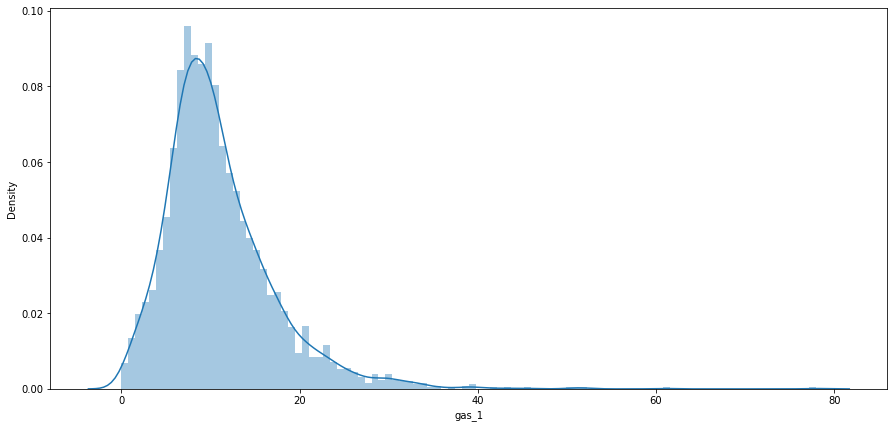

In [104]:
# построение графика распределения данных о продувке сплава газом: 

plt.figure(figsize=(15, 7))
sns.distplot(data_gas['gas_1'], bins=100);

Видим максимальное количество объема газа 77.995040. Возможно - это аномалия. Возможно это действительно так, например, было много итераций в этапе. Эти данные хорошо бы уточнить у технолога. На данном этапе удалять эти данные не будем.

В основном объем подачи газа распределен в промежутке от 7 до 14. 

Выведем партии с объемом продувки газом боле 40.

In [105]:
# вывод партий с объемом подачи газа более 40:

data_gas.query('gas_1 > 40')

,key,gas_1
116,117,50.581035
277,280,60.935689
319,322,77.995040
660,663,41.854643
1461,1464,43.655411
2105,2108,45.638999
2107,2110,52.142373
2567,2570,51.380229


In [106]:
# вывод данных об электродах для партии с самым большим 
# количеством потраченного газа:

data_arc.query('key == 322')

,key,start_arc,stop_arc,active_power,reactive_power,cycles
1487,322,2019-05-15 21:12:28,2019-05-15 21:14:57,0.248241,0.187737,13
1488,322,2019-05-15 21:17:00,2019-05-15 21:21:04,0.464677,0.346769,13
1489,322,2019-05-15 21:26:09,2019-05-15 21:31:26,0.328053,0.279597,13
1490,322,2019-05-15 21:40:12,2019-05-15 21:41:43,1.054529,0.814842,13
1491,322,2019-05-15 21:46:57,2019-05-15 21:49:02,0.746207,0.556786,13
1492,322,2019-05-15 21:51:58,2019-05-15 21:57:28,0.623596,0.461261,13
1493,322,2019-05-15 22:02:54,2019-05-15 22:04:42,0.893317,0.619611,13
1494,322,2019-05-15 22:08:33,2019-05-15 22:11:40,1.107495,0.823706,13
1495,322,2019-05-15 22:14:27,2019-05-15 22:16:19,0.870899,0.685100,13
1496,322,2019-05-15 22:40:56,2019-05-15 22:42:40,0.612125,0.441813,13


В партии наблюдаем 13 циклов. Максимально-зафиксированное число циклов равно 16. Найдем номер этой партии и посмотрим на объем потраченного газа.

In [107]:
# партия с максимальным кол-вом циклов (16):

data_arc.query('cycles == 16').head()

,key,start_arc,stop_arc,active_power,reactive_power,cycles
9734,2108,2019-07-27 10:41:13,2019-07-27 10:43:28,0.682359,0.536962,16
9735,2108,2019-07-27 11:07:24,2019-07-27 11:08:51,0.786992,0.582873,16
9736,2108,2019-07-27 11:13:37,2019-07-27 11:14:32,0.525551,0.329251,16
9737,2108,2019-07-27 11:15:45,2019-07-27 11:16:45,1.175194,0.789164,16
9738,2108,2019-07-27 11:19:26,2019-07-27 11:21:24,0.671852,0.508570,16


In [108]:
# вывод данных о потраченном кол-ве газа для 2108 партии:

data_gas.query('key == 2108')

,key,gas_1
2105,2108,45.638999


Газа потрачено намного больше среднего значения. Но меньше чем в 322 партии. 

Прослеживается зависимость кол-ва поданного газа от количества итераций. Что весьма логично. 

Поскольку данные о продувке газом нам предоставлены без времени, сверить со временем нагрева и подачей материалов не сможем.

Примем данные как есть. Удалять партии с большим количеством потраченного газа не будем.

#### Агрегирование данных об электродах и температуре

[Назад к содержанию](#Содержание)

Данные об электродах и результатах измерения температуры нам предоставлены по каждой итерации. В остальныех датафреймах данные уже агрегированы по этапам.

Для обучения моделей необходима финальная таблица со всеми признаками. Для чего необходимо агрегировать датафреймы с электродами и температурами по каждой партии, а затем добавить данные о засыпке сыпучих материалов и продувке газом.

Выведем несколько первых строк каждого датафрейма:

In [109]:
data_arc.head(10)

,key,start_arc,stop_arc,active_power,reactive_power,cycles
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,5
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,4
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,4
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,4
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,4
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,5


In [110]:
data_temp.head()

,key,temp_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


На текущий момент у нас есть следующие признаки.

Данные об электродах:

   - номер партии;
   - старт нагрева;
   - окончание нагрева;
   - активная мощность;
   - реактивная мощность;
   - кол-во циклов в этапе.
   
Данные об измерении температуры:

   - номер партии;
   - время замера;
   - температура.
   
Чтобы сохранить данные о реактивной и активной мощности после агрегирования, введем новые признаки: полная мощность и работа:

   - полную мощность вычислим как корень из суммы квадратов активной и реактивной мощности;
   - работу вычислим как произведение полной мощности на затраченное время нагрева.
   
Тогда после агрегирования данных у нас будет датафрейм со следующими признаками:

   - номер партии;
   - первая температура замера партии;
   - последняя температура замера партии;
   - кол-во циклов;
   - полная мощность;
   - работа;
   - затраченное время нагрева.
   
Поскольку данные нам предоставлены из разных источников, проверим их адекватность. Проверим соответствие времени нагрева и выполненных замеров температуры в пределах партии. Время нагрева и замеров температуры в пределах одной партии должно совпадать.

Во-первых посмотрим на количество итераций в каждой партии в датафрейме с температурами. Согласно технологическому процессу, количество замеров температуры должно быть на один больше, чем кол-во итераций с нагревом, т.к. сперва измеряют температуру, производят анализ, нагревают, добавляют добавки, продувают газом и снова измеряют температуру. 
   

In [111]:
# введем новый признак - кол-во циклов в партии temp_cycles
# заполним признак нулем:

data_temp['temp_cycles'] = 0
data_temp.head()

,key,temp_time,temperature,temp_cycles
0,1,2019-05-03 11:02:04,1571.0,0
1,1,2019-05-03 11:07:18,1604.0,0
2,1,2019-05-03 11:11:34,1618.0,0
3,1,2019-05-03 11:18:04,1601.0,0
4,1,2019-05-03 11:25:59,1606.0,0


In [112]:
# таблица с количеством итераций для каждой партии:

temp_cycles = data_temp.groupby('key').agg({'temp_cycles': 'count'})

In [113]:
# вывод первых строк: 

temp_cycles.head()

,temp_cycles
key,
1,6
2,5
3,6
4,5
5,5


In [114]:
# вывод последних строк: 

temp_cycles.tail()

,temp_cycles
key,
3237,6
3238,4
3239,9
3240,6
3241,6


Теперь выведем таблицу с количеством итераций нагрева:

In [115]:
cycles.head()

,cycles
key,
1,5
2,4
3,5
4,4
5,4


In [116]:
cycles.tail()

,cycles
key,
3237,5
3238,3
3239,8
3240,5
3241,5


Добавим кол-во итераций нагрева в датафрейм с измерениями температуры.

In [117]:
# добавление кол-ва итераций нагрева в data_temp:

data_temp = data_temp.merge(temp_cycles, on='key')

In [118]:
# вывод первых строк:

data_temp.head()

,key,temp_time,temperature,temp_cycles_x,temp_cycles_y
0,1,2019-05-03 11:02:04,1571.0,0,6
1,1,2019-05-03 11:07:18,1604.0,0,6
2,1,2019-05-03 11:11:34,1618.0,0,6
3,1,2019-05-03 11:18:04,1601.0,0,6
4,1,2019-05-03 11:25:59,1606.0,0,6


In [119]:
# удалим старый столбец с количеством циклов
# и переименуем признак с кол-вом циклов:

data_temp.drop('temp_cycles_x', axis=1, inplace=True)
data_temp = data_temp.rename(columns={'temp_cycles_y': 'temp_cycles'})


In [120]:
# проверка, вывод первых строк:

data_temp.head()

,key,temp_time,temperature,temp_cycles
0,1,2019-05-03 11:02:04,1571.0,6
1,1,2019-05-03 11:07:18,1604.0,6
2,1,2019-05-03 11:11:34,1618.0,6
3,1,2019-05-03 11:18:04,1601.0,6
4,1,2019-05-03 11:25:59,1606.0,6


In [121]:
# проверка, вывод последних строк:

data_temp.tail()

,key,temp_time,temperature,temp_cycles
18060,3241,2019-09-06 16:55:01,0.0,6
18061,3241,2019-09-06 17:06:38,0.0,6
18062,3241,2019-09-06 17:21:48,0.0,6
18063,3241,2019-09-06 17:24:44,0.0,6
18064,3241,2019-09-06 17:30:05,0.0,6


Действительно количество замеров температур больше на один, чем кол-во нагрева в пределах одной партии.

Также выявлен важный факт - последняя партия с замерами температур: 2499. А в датафрейме с электродами последняя партия - 3241. Выведем ниже:

In [122]:
# последние строки датафрейма с электродами:

data_arc.tail()

,key,start_arc,stop_arc,active_power,reactive_power,cycles
14867,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,5
14868,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,5
14869,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,5
14870,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,5
14871,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347,5


In [123]:
# подсчет уникальных значений партий датафрейма с температурами:

data_temp.key.nunique()

3211

In [124]:
# проверка на дубликаты:

data_temp.duplicated().sum()

0

Таким образом обнаружили, что всего партий с замером температуры у нас 3211. Т.е. получается, что для некоторых партий с данными об электродах у нас отсутствовуют данные об измерении температуры. Для обучения моделей это не приемлемо, т.к. нам обязательно необходимо знать первичную и конечную температуру каждой партии.

In [125]:
# проверка на уникальность партий:

data_arc.key.nunique()

3213

Партий меньше, чем в датафрейме с температурами, т.к. из датафрейма с электродами уже были удалены партии с единичными замерами. 

Теперь проверим соответствие времени нагрева и выполненных замеров температуры в пределах партии. Для примера возьмем партию 10.

In [126]:
# данные о нагреве 10 партии:

data_arc.query('key == 10')

,key,start_arc,stop_arc,active_power,reactive_power,cycles
39,10,2019-05-03 16:14:09,2019-05-03 16:16:36,0.423798,0.296542,6
40,10,2019-05-03 16:17:59,2019-05-03 16:22:16,0.627009,0.432609,6
41,10,2019-05-03 16:24:39,2019-05-03 16:26:49,0.467115,0.313622,6
42,10,2019-05-03 16:28:06,2019-05-03 16:29:41,0.522005,0.361521,6
43,10,2019-05-03 16:32:25,2019-05-03 16:34:09,0.502584,0.340440,6
44,10,2019-05-03 16:36:19,2019-05-03 16:37:51,0.576267,0.410207,6


In [127]:
# данные об измерениях температуры 10 партии:

data_temp.query('key == 10')


,key,temp_time,temperature,temp_cycles
48,10,2019-05-03 16:13:59,1574.0,7
49,10,2019-05-03 16:17:49,1580.0,7
50,10,2019-05-03 16:24:29,1585.0,7
51,10,2019-05-03 16:27:56,1586.0,7
52,10,2019-05-03 16:32:15,1586.0,7
53,10,2019-05-03 16:36:09,1586.0,7
54,10,2019-05-03 16:39:50,1593.0,7


Замеры температуры:

   - 1-ый замер: до старта первого нагрева;
   - 2-ой замер: после останова первого нагрева и до запуска второго нагрева;
   - 3-ий замер: после второго нагрева и до запуска третьего нагрева;
   - 4-ый замер: после третьего нагрева и до запуска четвертого;
   - 5-ый замер: после четветого нагрева и до запуска пятого;
   - 6-ой замер: после пятого нагрева и до запуска шестого;
   - 7-ой замер: после останова шестого замера.
   
Таким образом полученные данные соответствуют технологическому процессу.


In [128]:
# уникальное кол-во произведенных замеров темп-ры:

data_temp.temp_cycles.unique()

array([ 6,  5,  7,  4,  8, 13, 11, 14,  2,  3,  9,  1, 10, 12, 16, 17, 15])

Теперь оставим только первый и последний замер температуры для каждой партии. Для этого сделаем датафрейм с первичной температурой, конечной, а также с первичной и конечной датой измерения.


In [129]:
# группировка датафрейма с температурами
# оставляем время первого и последнего замера в каждой партии
# и значения первой и конечной температуры:

data_temp = data_temp.groupby(['key'])[['temp_time', 'temperature']] \
        .agg(['first', 'last']) \
        .reset_index()

In [130]:
# проверка, вывод первых нескольких строк:

data_temp.head()

key           temp_time                     temperature        
                    first                last       first    last
0   1 2019-05-03 11:02:04 2019-05-03 11:30:38      1571.0  1613.0
1   2 2019-05-03 11:34:04 2019-05-03 11:55:09      1581.0  1602.0
2   3 2019-05-03 12:06:44 2019-05-03 12:35:57      1596.0  1599.0
3   4 2019-05-03 12:39:27 2019-05-03 12:59:47      1601.0  1625.0
4   5 2019-05-03 13:11:03 2019-05-03 13:36:39      1576.0  1602.0

In [131]:
# проверка, вывод последних нескольких строк:

data_temp.tail()

key           temp_time                     temperature     
                         first                last       first last
3206  3237 2019-09-06 11:31:15 2019-09-06 11:55:45      1569.0  0.0
3207  3238 2019-09-06 12:16:15 2019-09-06 12:34:37      1584.0  0.0
3208  3239 2019-09-06 14:16:50 2019-09-06 15:09:55      1598.0  0.0
3209  3240 2019-09-06 15:25:21 2019-09-06 16:35:26      1617.0  0.0
3210  3241 2019-09-06 16:48:55 2019-09-06 17:30:05      1586.0  0.0

In [132]:
# сброс мультииндекса:

data_temp.columns = data_temp.columns.droplevel(level=1)
data_temp.head()


,key,temp_time,temp_time,temperature,temperature
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


In [133]:
# переименование столбцов:

data_temp.columns = ['key', 'temp_time_1', 'temp_time_2', 'temp_1', 'temp_2']


In [134]:
# проверка:

data_temp.head()


,key,temp_time_1,temp_time_2,temp_1,temp_2
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


In [135]:
data_temp.tail()

,key,temp_time_1,temp_time_2,temp_1,temp_2
3206,3237,2019-09-06 11:31:15,2019-09-06 11:55:45,1569.0,0.0
3207,3238,2019-09-06 12:16:15,2019-09-06 12:34:37,1584.0,0.0
3208,3239,2019-09-06 14:16:50,2019-09-06 15:09:55,1598.0,0.0
3209,3240,2019-09-06 15:25:21,2019-09-06 16:35:26,1617.0,0.0
3210,3241,2019-09-06 16:48:55,2019-09-06 17:30:05,1586.0,0.0


Проанализируем партии, в которых первичная или конечная температура оказались без замера. Такие партии нужно будет исключить из датафрейма. Считаем это бракованной партией, т.к. начальная и конечная температура - это необходимый признак для обучения модели и целевой признак, соответственно.

In [136]:
# поиск партий с нулевой первичной или конечной температурой:

data_temp.query('temp_1 == 0 or temp_2 == 0')

,key,temp_time_1,temp_time_2,temp_1,temp_2
2473,2500,2019-08-10 14:04:39,2019-08-10 14:29:39,1539.0,0.0
2474,2501,2019-08-10 14:41:14,2019-08-10 15:29:00,1587.0,0.0
2475,2502,2019-08-10 15:39:39,2019-08-10 16:04:55,1583.0,0.0
2476,2503,2019-08-10 16:27:44,2019-08-10 17:14:24,1603.0,0.0
2477,2504,2019-08-10 17:31:43,2019-08-10 18:03:42,1583.0,0.0
...,...,...,...,...,...
3206,3237,2019-09-06 11:31:15,2019-09-06 11:55:45,1569.0,0.0
3207,3238,2019-09-06 12:16:15,2019-09-06 12:34:37,1584.0,0.0
3208,3239,2019-09-06 14:16:50,2019-09-06 15:09:55,1598.0,0.0
3209,3240,2019-09-06 15:25:21,2019-09-06 16:35:26,1617.0,0.0


Обнаружили 738 таких партий, удалим их полностью.

In [137]:
# парти с нулевой первичной или конечной температурой:
bad_temp = data_temp.query('temp_1 == 0 or temp_2 == 0')['key']


# удаление партий с нулевой первичной или конечной температурой:
data_temp = data_temp[data_temp.key.isin(bad_temp) == False]

# сброс индексов:
data_temp.reset_index(drop= True, inplace= True)

In [138]:
# проверка:

data_temp.query('temp_1 == 0 or temp_2 == 0')

,key,temp_time_1,temp_time_2,temp_1,temp_2


In [139]:
# проверка на дубликаты:

data_temp.duplicated().sum()

0

Теперь в датафрейме с замерами температур содержатся только температура первого и последнего замеров, а также дата и время замеров. 

Далее агрегируем датафрейм с электродами: оставим данные по первичному и конечному нагреву, вместо активной и реактивной энергии подсчитаем суммарное значение, а также оставим данные по количеству итераций в партии и введем новые параметры: 

   - время нагрева (как разность между стартом нагрева и остановом в секундах);
   - полная мощность (s) - как корень из суммы квадратов активной и реактивной мощности;
   - работа (a) - как произведение полной мощности на время нагрева;
   - косинус фи (cos_f) - как отношение активной мощности к полной мощности.
   

In [140]:
# ввод времени нагрева:

data_arc['heat_time'] = data_arc['stop_arc'] - data_arc['start_arc']

In [141]:
# перевод времени нагрева в секунды:

data_arc['heat_time'] = data_arc['heat_time'].dt.seconds

In [142]:
# добавление полной мощности:

data_arc['s'] = np.sqrt(data_arc['active_power'] ** 2 + data_arc['reactive_power'] ** 2)

In [143]:
# добавление работы:

data_arc['a'] = data_arc.s * data_arc.heat_time

In [144]:
# добавление cos_f:

data_arc['cos_f'] = data_arc.active_power / data_arc.s

In [145]:
# проверка

data_arc.head()

,key,start_arc,stop_arc,active_power,reactive_power,cycles,heat_time,s,a,cos_f
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,5,228,0.371123,84.616003,0.822181
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,5,185,0.902319,166.928978,0.848545
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,5,172,0.722536,124.276277,0.803161
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,5,365,0.642824,234.630603,0.806591
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,5,148,1.079934,159.830252,0.802950


In [146]:
# группируем данные по этапам,
# выведем столбцы со стартом и остановом нагрева,
# вместо активной и реактивной мощности вычислим суммарное значение за этап,
# оставим количество выполняемых итераций
# подсчитаем суммарное время нагрева
# подсчитаем суммарную полную мощность;
# подсчитаем суммарную работу
# подсчитаем суммарный косинус фи:

data_arc = data_arc.groupby(['key']) \
        [['start_arc', 'stop_arc', 'active_power', 'reactive_power', 'cycles', 'heat_time', 's', 'a', 'cos_f']] \
        .agg({'start_arc' : 'first', 
              'stop_arc' : 'last',
             'active_power' : 'sum',
             'reactive_power' : 'sum',
             'cycles' : 'mean',
             'heat_time': 'sum',
             's': 'sum',
             'a': 'sum',
             'cos_f': 'mean'}) \
        .reset_index()


In [147]:
# удаление старых признаков start_arc и stop_arc:

data_arc.drop(['start_arc', 'stop_arc'], axis=1, inplace=True)


In [148]:
# проверка:

data_arc.head()


,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f
0,1,3.036730,2.142821,5,1098,3.718736,770.282114,0.816686
1,2,2.139408,1.453357,4,811,2.588349,481.760005,0.825276
2,3,4.063641,2.937457,5,655,5.019223,722.837668,0.809724
3,4,2.706489,2.056992,4,741,3.400038,683.455597,0.793923
4,5,2.252950,1.687991,4,869,2.816980,512.169934,0.796818


Далее объединим два датафрейма с электродами и с температурами. В качестве ключа будем использовать номер партии.

In [149]:
# объединение датафреймов с электродами и температурами в один:

data_arc_temp = data_arc.merge(data_temp, on='key', how='inner')


In [150]:
# проверка по первым строкам:

data_arc_temp.head()

,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_time_1,temp_time_2,temp_1,temp_2
0,1,3.036730,2.142821,5,1098,3.718736,770.282114,0.816686,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2.139408,1.453357,4,811,2.588349,481.760005,0.825276,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,4.063641,2.937457,5,655,5.019223,722.837668,0.809724,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2.706489,2.056992,4,741,3.400038,683.455597,0.793923,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2.252950,1.687991,4,869,2.816980,512.169934,0.796818,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


In [151]:
# проверка по последним строкам:

data_arc_temp.tail()

,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_time_1,temp_time_2,temp_1,temp_2
2465,2495,3.168133,2.210936,4,723,3.868721,694.177326,0.812727,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0
2466,2496,4.174918,2.872031,6,940,5.070316,815.818538,0.819606,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0
2467,2497,3.605239,2.452092,3,569,4.360918,823.020520,0.827613,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0
2468,2498,3.202310,2.239820,5,750,3.909917,581.810739,0.819245,2019-08-10 12:58:11,2019-08-10 13:23:31,1591.0,1594.0
2469,2499,1.737084,1.296836,4,883,2.169252,532.386183,0.800782,2019-08-10 13:33:21,2019-08-10 13:58:58,1569.0,1603.0


Введем новый признак - время между замерами температур.

In [152]:
data_arc_temp['delta_temp_time'] = data_arc_temp['temp_time_2'] - data_arc_temp['temp_time_1']

In [153]:
# перевод времени между замерами температур:

data_arc_temp['delta_temp_time'] = data_arc_temp['delta_temp_time'].dt.seconds

In [154]:
# удаление признаков temp_time_1 и temp_time_2:

data_arc_temp.drop(['temp_time_1', 'temp_time_2'], axis=1, inplace=True)

In [155]:
# проверка по первым строкам:

data_arc_temp.head()

,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_1,temp_2,delta_temp_time
0,1,3.036730,2.142821,5,1098,3.718736,770.282114,0.816686,1571.0,1613.0,1714
1,2,2.139408,1.453357,4,811,2.588349,481.760005,0.825276,1581.0,1602.0,1265
2,3,4.063641,2.937457,5,655,5.019223,722.837668,0.809724,1596.0,1599.0,1753
3,4,2.706489,2.056992,4,741,3.400038,683.455597,0.793923,1601.0,1625.0,1220
4,5,2.252950,1.687991,4,869,2.816980,512.169934,0.796818,1576.0,1602.0,1536


In [156]:
# проверка по последним строкам:

data_arc_temp.tail()

,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_1,temp_2,delta_temp_time
2465,2495,3.168133,2.210936,4,723,3.868721,694.177326,0.812727,1570.0,1591.0,1380
2466,2496,4.174918,2.872031,6,940,5.070316,815.818538,0.819606,1554.0,1591.0,1705
2467,2497,3.605239,2.452092,3,569,4.360918,823.020520,0.827613,1571.0,1589.0,962
2468,2498,3.202310,2.239820,5,750,3.909917,581.810739,0.819245,1591.0,1594.0,1520
2469,2499,1.737084,1.296836,4,883,2.169252,532.386183,0.800782,1569.0,1603.0,1537


На данном этапе была произведена агрегация двух датафреймов: с данными об электродах и данными с замерами температур. Объединили две таблицы в одну `data_arc_temp`. Для этого выполнили следующие шаги:

   - убедились в адекватности полученных данных по времени нагрева и времени измерения температуры;
   - определили номера партий, для которых произведены как минимум два измерения температуры;
   - агрегировали данные по электродам;
   - ввели новые признаки по электродам - `время нагрева`, `работу`, `полную мощность`, `cos_f` и `количество итераций нагрева в каждой партии`;
   - в таблице с температурами были оставлены первая температура замера и последняя;
   
Объединенный датафрейм `data_arc_temp` содержит следующие признаки:

   - номер партии;
   - активная мощность;
   - реактивная мощность;
   - количество итераций нагрева;
   - время нагрева (сек);
   - полная мощность;
   - работа;
   - cos_f;
   - значение первичного замера температуры;
   - значение последнего замера температуры;
   - время между замерами температур.
   

### Подготовка финального датафрейма

#### Объединение датафреймов

[Назад к содержанию](#Содержание)

Подготовим финальный датафрейм для обучения моделей. 

В объединенный датафрейм с электродами и температурами добавим датафреймы с добавлением материалов и продувке газом. Объединим по номеру партии. Данные по времени засыпки материалов использовать не будем - для обучения модели эти признаки не нужны.

В финальный датафрейм должны попасть партии, данные по которым содержаться во всех датафреймах.

После объединения проверим финальный датафрейм на важность признаков и мультиколлинеарность. При необходимости избавимся от некоторых признаков. 


**1. Добавим данные о подаче сыпучих материалов**

In [157]:
# подготовка финального датафрейма
# добавление данных о подаче сыпучих материалов
# добавляем по номеру партии

data = data_arc_temp.merge(data_bulk, how='inner', on='key')

In [158]:
# проверка по первым строкам:

data.head()

,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_1,temp_2,delta_temp_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,3.036730,2.142821,5,1098,3.718736,770.282114,0.816686,1571.0,1613.0,1714,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2.139408,1.453357,4,811,2.588349,481.760005,0.825276,1581.0,1602.0,1265,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,4.063641,2.937457,5,655,5.019223,722.837668,0.809724,1596.0,1599.0,1753,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2.706489,2.056992,4,741,3.400038,683.455597,0.793923,1601.0,1625.0,1220,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2.252950,1.687991,4,869,2.816980,512.169934,0.796818,1576.0,1602.0,1536,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [159]:
# проверка по последним строкам:

data.tail()

,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_1,temp_2,delta_temp_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2397,2495,3.168133,2.210936,4,723,3.868721,694.177326,0.812727,1570.0,1591.0,1380,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2398,2496,4.174918,2.872031,6,940,5.070316,815.818538,0.819606,1554.0,1591.0,1705,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2399,2497,3.605239,2.452092,3,569,4.360918,823.020520,0.827613,1571.0,1589.0,962,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2400,2498,3.202310,2.239820,5,750,3.909917,581.810739,0.819245,1591.0,1594.0,1520,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0
2401,2499,1.737084,1.296836,4,883,2.169252,532.386183,0.800782,1569.0,1603.0,1537,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0


**2. Добавим данные о подаче проволочных материалов**

In [160]:
# подготовка финального датафрейма
# добавление данных о подаче проволочных материалов
# добавляем по номеру партии

data = data.merge(data_wire, how='inner', on='key')


In [161]:
# проверка по первым строкам:

data.head()

,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_1,temp_2,delta_temp_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,3.036730,2.142821,5,1098,3.718736,770.282114,0.816686,1571.0,1613.0,1714,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2.139408,1.453357,4,811,2.588349,481.760005,0.825276,1581.0,1602.0,1265,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,4.063641,2.937457,5,655,5.019223,722.837668,0.809724,1596.0,1599.0,1753,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2.706489,2.056992,4,741,3.400038,683.455597,0.793923,1601.0,1625.0,1220,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2.252950,1.687991,4,869,2.816980,512.169934,0.796818,1576.0,1602.0,1536,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
# проверка по последним строкам:

data.tail()

,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_1,temp_2,delta_temp_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
2321,2495,3.168133,2.210936,4,723,3.868721,694.177326,0.812727,1570.0,1591.0,1380,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2322,2496,4.174918,2.872031,6,940,5.070316,815.818538,0.819606,1554.0,1591.0,1705,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2323,2497,3.605239,2.452092,3,569,4.360918,823.020520,0.827613,1571.0,1589.0,962,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2324,2498,3.202310,2.239820,5,750,3.909917,581.810739,0.819245,1591.0,1594.0,1520,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2325,2499,1.737084,1.296836,4,883,2.169252,532.386183,0.800782,1569.0,1603.0,1537,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0


**3. Добавим данные о продувке сплава газом**

In [163]:
# подготовка финального датафрейма
# добавление данных о продувке сплава газом
# добавляем по номеру партии

data = data.merge(data_gas, how='inner', on='key')


In [164]:
# проверка по первым строкам:

data.head()

,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_1,temp_2,delta_temp_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,gas_1
0,1,3.036730,2.142821,5,1098,3.718736,770.282114,0.816686,1571.0,1613.0,1714,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,2.139408,1.453357,4,811,2.588349,481.760005,0.825276,1581.0,1602.0,1265,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,4.063641,2.937457,5,655,5.019223,722.837668,0.809724,1596.0,1599.0,1753,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,2.706489,2.056992,4,741,3.400038,683.455597,0.793923,1601.0,1625.0,1220,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,2.252950,1.687991,4,869,2.816980,512.169934,0.796818,1576.0,1602.0,1536,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [165]:
# проверка по последним строкам:

data.tail()

,key,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_1,temp_2,delta_temp_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,gas_1
2319,2495,3.168133,2.210936,4,723,3.868721,694.177326,0.812727,1570.0,1591.0,1380,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2320,2496,4.174918,2.872031,6,940,5.070316,815.818538,0.819606,1554.0,1591.0,1705,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2321,2497,3.605239,2.452092,3,569,4.360918,823.020520,0.827613,1571.0,1589.0,962,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2322,2498,3.202310,2.239820,5,750,3.909917,581.810739,0.819245,1591.0,1594.0,1520,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,14.953657
2323,2499,1.737084,1.296836,4,883,2.169252,532.386183,0.800782,1569.0,1603.0,1537,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,11.336151


In [166]:
# вывод общей информации:

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2324 non-null   int64  
 1   active_power     2324 non-null   float64
 2   reactive_power   2324 non-null   float64
 3   cycles           2324 non-null   int64  
 4   heat_time        2324 non-null   int64  
 5   s                2324 non-null   float64
 6   a                2324 non-null   float64
 7   cos_f            2324 non-null   float64
 8   temp_1           2324 non-null   float64
 9   temp_2           2324 non-null   float64
 10  delta_temp_time  2324 non-null   int64  
 11  Bulk 1           2324 non-null   float64
 12  Bulk 2           2324 non-null   float64
 13  Bulk 3           2324 non-null   float64
 14  Bulk 4           2324 non-null   float64
 15  Bulk 5           2324 non-null   float64
 16  Bulk 6           2324 non-null   float64
 17  Bulk 7        

Подготовили финальный датафрейм data. В него вошли следующие призаки:

   - активная мощность;
   - реактивная мощность;
   - время нагрева;
   - количество итераций нагрева;
   - время нагрева (сек);
   - время между нагревом;
   - полная мощность;
   - работа;
   - cos_f;
   - первичный замер температуры;
   - последний замер температуры;
   - данные о подаче всех сыпучих материалов;
   - данные о подаче некоторых проволочных материалов;
   - кол-во раз добавленных материалов (сыпучих и проволочных);
   - суммарный объем редких материалов (сыпучих и проволочных);
   - данные о продувке сплава газом.

Пропуски в датафрейме отсутствуют.

#### Анализ финального датафрейма

[Назад к содержанию](#Содержание)

Построим тепловую карту с корреляционной зависимостью признаков финального датафрейма.

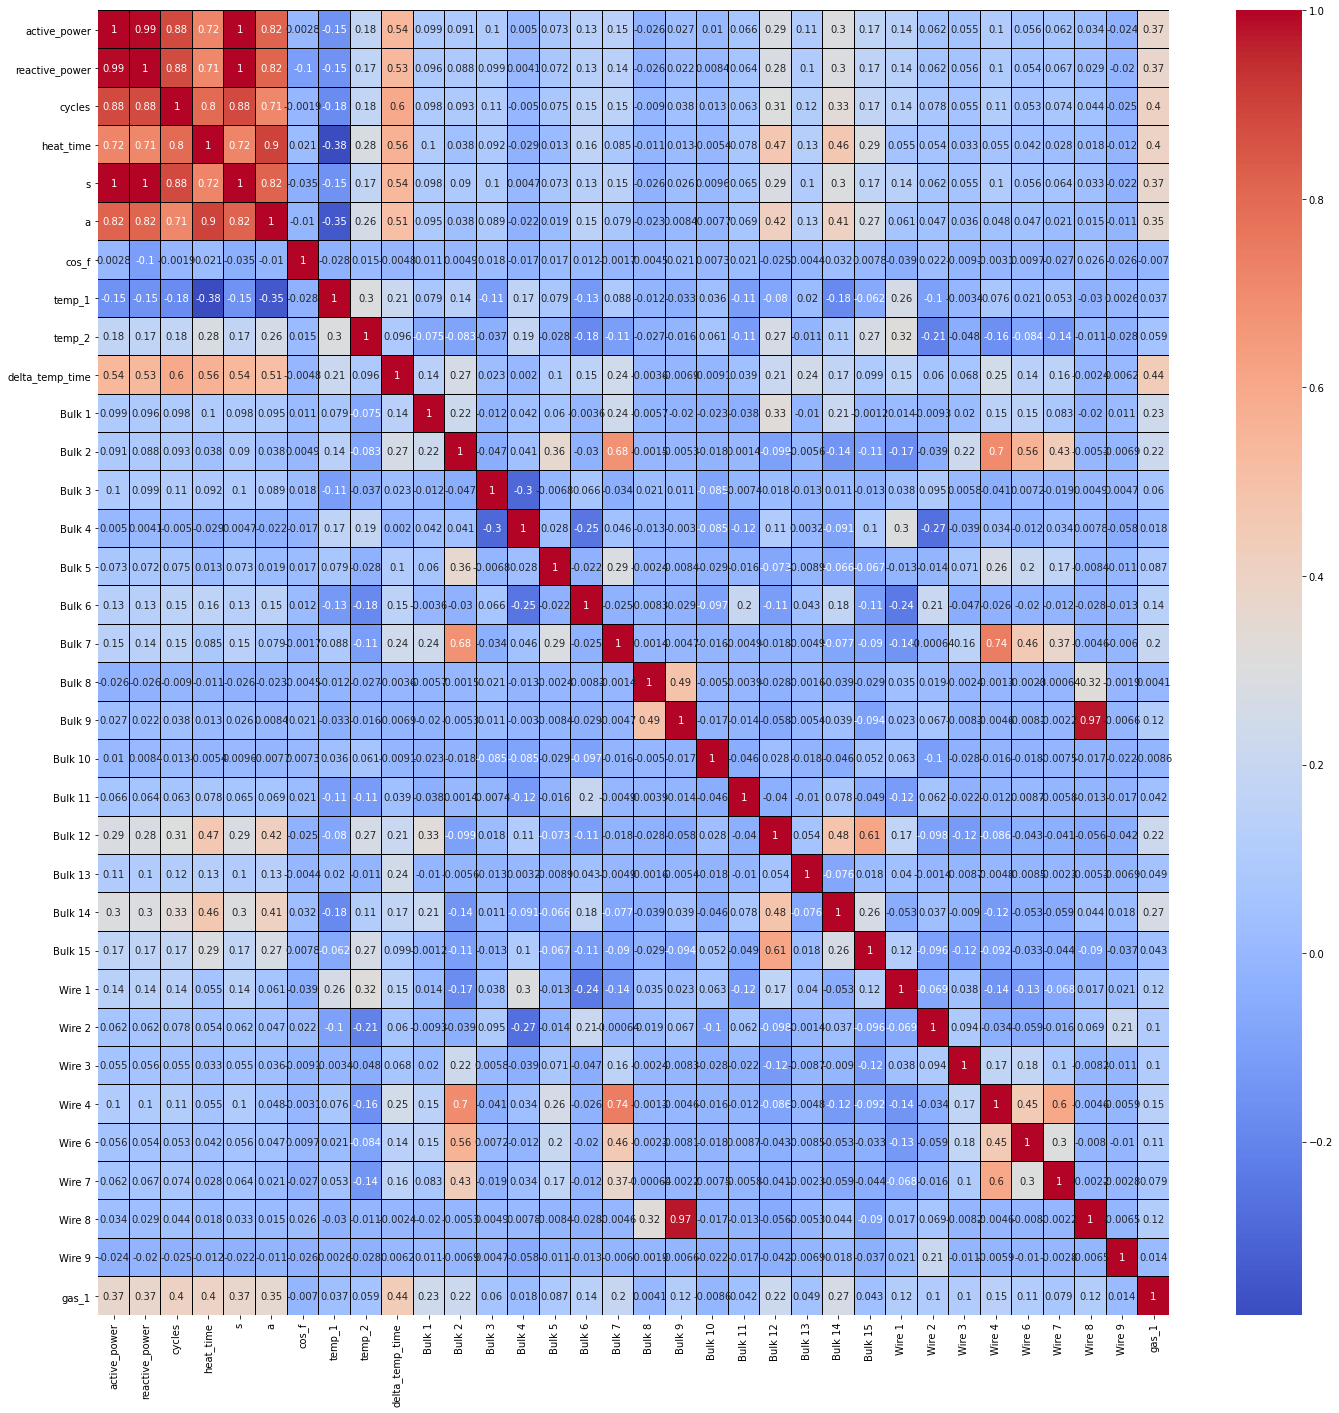

In [171]:
# тепловая карта корреляционной зависимости признаков:

fig, ax = plt.subplots(figsize=(24, 24))

sns.heatmap \
    (data.corr(), cmap="coolwarm", annot= True, \
     linewidths=.01, linecolor='black', fmt='.2g');

Удалим номер партии, т.к. большой роли он не сыграет, к тому же на производстве может измениться кодировка нумерации партии, например, могут быть добавлены буквенные обозначения.

In [172]:
# удалим мало значащие признаки:

data.drop('key', axis = 1, inplace=True)

KeyError: "['key'] not found in axis"

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   active_power     2324 non-null   float64
 1   reactive_power   2324 non-null   float64
 2   cycles           2324 non-null   int64  
 3   heat_time        2324 non-null   int64  
 4   s                2324 non-null   float64
 5   a                2324 non-null   float64
 6   cos_f            2324 non-null   float64
 7   temp_1           2324 non-null   float64
 8   temp_2           2324 non-null   float64
 9   delta_temp_time  2324 non-null   int64  
 10  Bulk 1           2324 non-null   float64
 11  Bulk 2           2324 non-null   float64
 12  Bulk 3           2324 non-null   float64
 13  Bulk 4           2324 non-null   float64
 14  Bulk 5           2324 non-null   float64
 15  Bulk 6           2324 non-null   float64
 16  Bulk 7           2324 non-null   float64
 17  Bulk 8        

Сделаем отдельный датафрейм для обучения линейной регрессии.

In [174]:
data_lin = data.copy()

Удалим следующие признаки, т.к. они сильно коррелируют друг с другом:

   - активная мощность;
   - количество итераций нагрева;
   - время нагрева;
   - работу;
   - полную мощность;
   - Wire 8, т.к. сильно коррелирует с Bulk 9

In [175]:
bad_features = [
    'active_power',
    'cycles',
    'heat_time',
    'a',
    's',
    'Wire 8'
]

In [176]:
data_lin.drop(bad_features, axis=1, inplace=True)

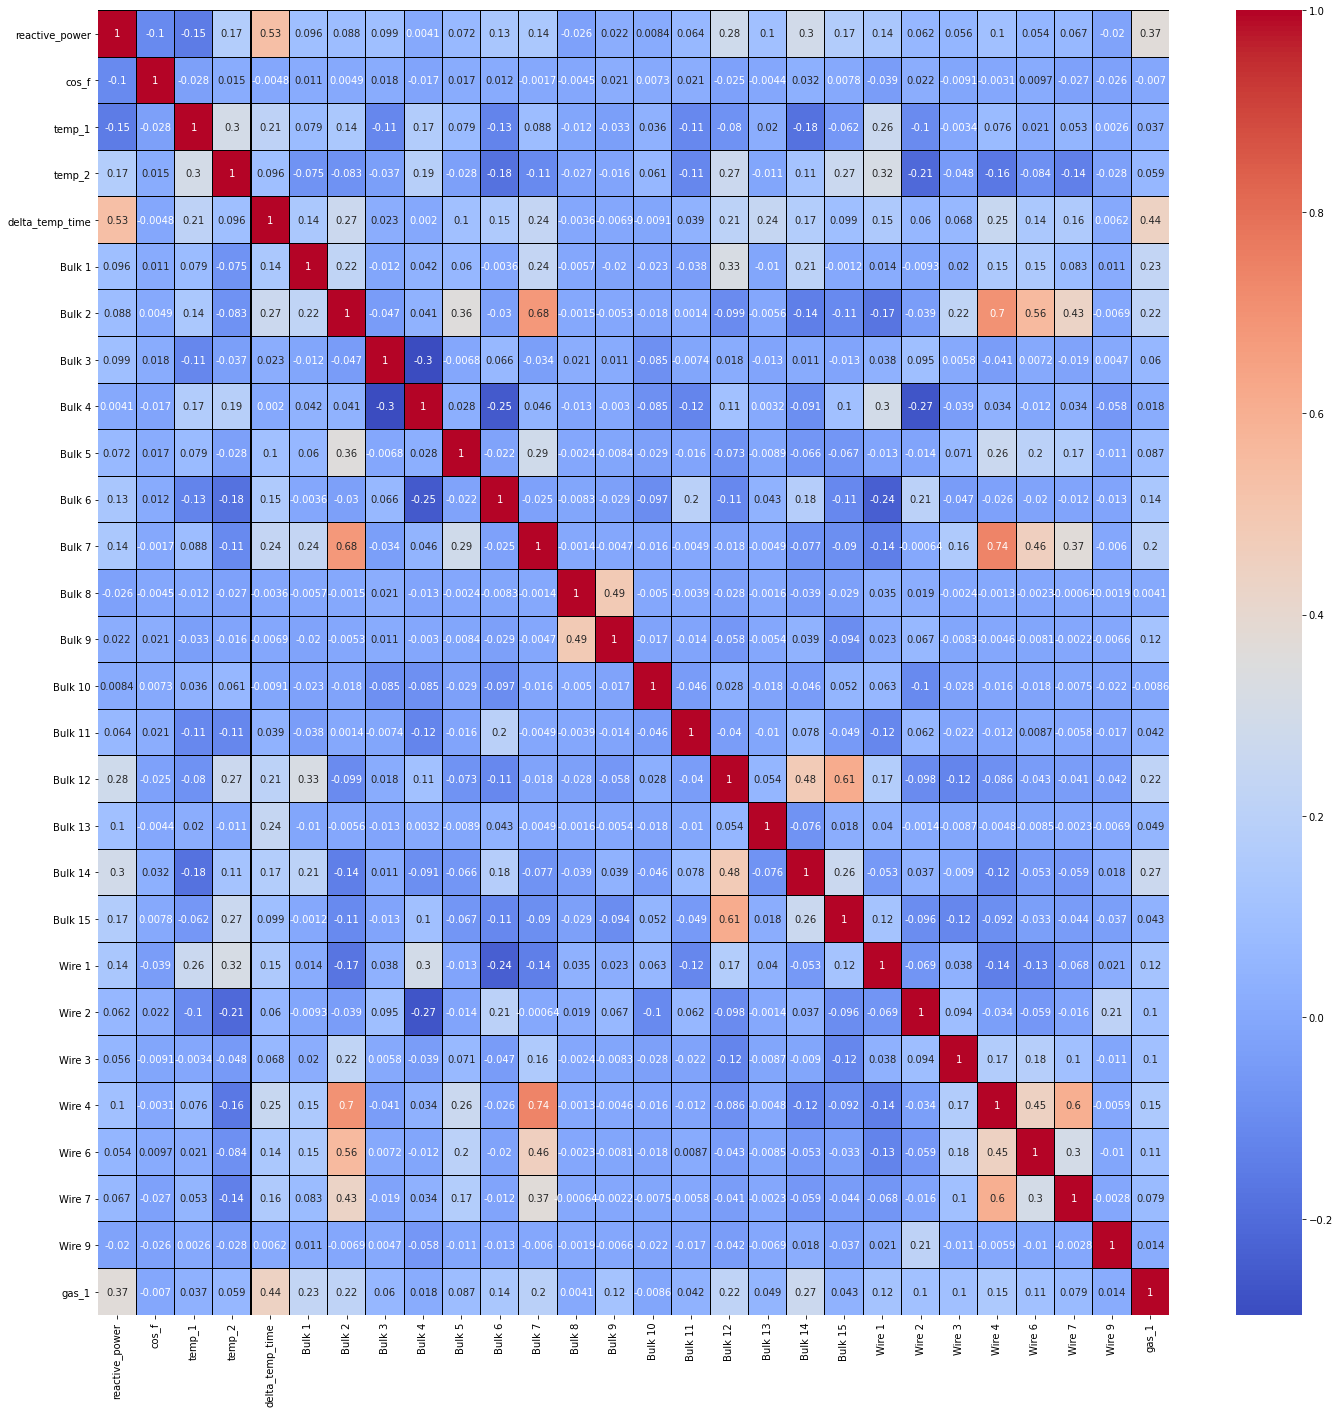

In [177]:
# тепловая карта корреляционной зависимости признаков:

fig, ax = plt.subplots(figsize=(24, 24))

sns.heatmap \
    (data_lin.corr(), cmap="coolwarm", annot= True, \
     linewidths=.01, linecolor='black', fmt='.2g');

На данном этапе готовы два финальных датафрейма - `data_lin` и `data` - для обучения линейной модели и остальных моделей. Признаки в `data_lin` не коррелируют между собой.

### Обучение модели

Поскольку у нас стоит задача поиска конечной температуры, то это задача регрессии. 

Для ее решения будем обучать несколько моделей. С задачами регрессии хорошо справляются модели, обученные с помощью градиентного бустинга. Поэтому задействуем `LGBM`, `CatBoostRegression`, `XGBoost` и `Ridge`. Также проверим `линейную регрессию` и `случайный лес в регрессии`. Линейную регрессию будем использовать в качестве baseline-модели.

Для поиска оптимальных параметров моделей будем использовать `RandomizedSearchCV`, т.к. он быстрее работает по сравнению с GridSearchCV (хотя возможно ухудшение качества модели). 

Также стандартизируем значения признаков для обучения линейной регрессии.

#### Подготовка обучающей и тестовой выборок

[Назад к содержанию](#Содержание)

Создадим переменные для признаков и целевого признака:

   - в качестве целевого признака `target` будем использовать значения из столбца `temp_2`;
   - в качестве признаков `features` будем использовать все признаки, за исключением целевого.
   
Пропишем переменные:

In [178]:
# признаки: 
features = data.drop('temp_2', axis=1)

# целевой признак:
target = data['temp_2']

# признаки для линейной регрессии: 
features_lin = data_lin.drop('temp_2', axis=1)

# целевой признак линейной регрессии:
target_lin = data_lin['temp_2']

In [179]:
print(data.shape)
print(data_lin.shape)

(2324, 34)
(2324, 28)


In [180]:
# выделим 90% под обучающую выборку
# оставшиеся 10% - под тестовую:

features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size = 0.1, random_state=RANDOM_STATE)

features_train_lin, features_test_lin, target_train_lin, target_test_lin = \
    train_test_split(features_lin, target_lin, test_size = 0.1, random_state=RANDOM_STATE)

In [181]:
# проверим количество получившихся объектов:

print('features_train:', features_train.shape)
print('features_test:', features_test.shape)
print('target_train:', target_train.shape)
print('target_test:', target_test.shape)

print('features_train_lin:', features_train_lin.shape)
print('features_test_lin:', features_test_lin.shape)
print('target_train_lin:', target_train_lin.shape)
print('target_test_lin:', target_test_lin.shape)


features_train: (1859, 33)
features_test: (465, 33)
target_train: (1859,)
target_test: (465,)
features_train_lin: (1859, 27)
features_test_lin: (465, 27)
target_train_lin: (1859,)
target_test_lin: (465,)


Данные по выборкам разделили верно. 

Финальный датафрейм разбили на обучающую и тестовую выборки в соотношении 90% и 10%, соответственно:

   - 90% выделили под обучающую выборку: `features_train` и `target_train`;
   - 10% под тестовую выборку: `features_test` и `target_test`.
   
Также для линейной регрессии:
   
   - 90% выделили под обучающую выборку: `features_train_lin` и `target_train_lin`;
   - 10% под тестовую выборку: `features_test_lin` и `target_test_lin`. 
   

Выполним `стандартизацию` численных признаков для линейной регрессии.

In [182]:
features_train_scaled = features_train_lin.copy()
features_test_scaled = features_test_lin.copy()

In [183]:
# сделаем переменную numeric со списком всех численных признаков:
numeric = list(features_train_scaled)

# создаем объект структуры StandardScaler():
scaler = StandardScaler()

# настройка обучающих данных:
scaler.fit(features_train_scaled[numeric])

# преобразование обучающей и тестовой выборок функцией transform():
features_train_scaled[numeric] = scaler.transform(features_train_scaled[numeric])
features_test_scaled[numeric] = scaler.transform(features_test_scaled[numeric])

# проверка
print('features_train_scaled:')
display(features_train_scaled.describe())
print()
print('features_test_scaled:')
display(features_test_scaled.describe())

features_train_scaled:


,reactive_power,cos_f,temp_1,delta_temp_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9,gas_1
count,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1859.000000,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03,1.859000e+03
mean,1.691313e-16,-1.934022e-15,-9.106337e-16,-8.169904e-17,-1.528871e-17,1.146653e-17,1.911089e-18,-1.911089e-18,2.723301e-17,-4.491058e-17,9.555443e-19,0.000000,2.675524e-17,-6.115483e-17,8.599899e-18,2.771078e-17,-1.528871e-17,-8.408790e-17,4.777721e-18,-3.334850e-16,1.012877e-16,5.733266e-18,-4.299949e-18,1.911089e-18,-2.484415e-17,3.439959e-17,1.337762e-16
std,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00,1.000269e+00
min,-2.308661e+00,-4.737315e+00,-2.893999e+00,-1.389521e+00,-2.798742e-01,-7.310217e-02,-6.359824e-01,-6.226719e-01,-1.144132e-01,-4.136515e-01,-6.607588e-02,-0.023199,-6.614249e-02,-2.470559e-01,-1.950461e-01,-1.308552e+00,-7.413718e-02,-1.866685e+00,-1.412181e+00,-2.318226e+00,-5.336082e-01,-1.168061e-01,-6.217298e-02,-1.203839e-01,-2.650805e-02,-9.877603e-02,-1.756199e+00
25%,-6.810882e-01,-6.034153e-01,-6.885650e-01,-5.208638e-01,-2.798742e-01,-7.310217e-02,-6.359824e-01,-6.226719e-01,-1.144132e-01,-4.136515e-01,-6.607588e-02,-0.023199,-6.614249e-02,-2.470559e-01,-1.950461e-01,-6.450111e-01,-7.413718e-02,-5.857528e-01,-1.412181e+00,-6.767082e-01,-5.336082e-01,-1.168061e-01,-6.217298e-02,-1.203839e-01,-2.650805e-02,-9.877603e-02,-6.205830e-01
50%,-8.695247e-02,4.278888e-02,-5.238213e-02,-2.025876e-01,-2.798742e-01,-7.310217e-02,-6.359824e-01,-6.226719e-01,-1.144132e-01,-4.136515e-01,-6.607588e-02,-0.023199,-6.614249e-02,-2.470559e-01,-1.950461e-01,-6.747760e-03,-7.413718e-02,-4.898117e-02,-1.542264e-01,-3.303424e-02,-5.336082e-01,-1.168061e-01,-6.217298e-02,-1.203839e-01,-2.650805e-02,-9.877603e-02,-1.921345e-01
75%,5.809542e-01,6.567324e-01,6.686251e-01,3.290309e-01,-2.798742e-01,-7.310217e-02,4.505971e-01,6.578385e-01,-1.144132e-01,-4.136515e-01,-6.607588e-02,-0.023199,-6.614249e-02,-2.470559e-01,-1.950461e-01,4.703699e-01,-7.413718e-02,6.219834e-01,1.008789e+00,5.855904e-01,1.901533e-01,-1.168061e-01,-6.217298e-02,-1.203839e-01,-2.650805e-02,-9.877603e-02,3.965031e-01
max,7.279543e+00,3.694014e+00,3.086120e+00,1.482658e+01,1.433713e+01,1.711900e+01,5.379958e+00,4.121232e+00,2.580083e+01,6.826594e+00,2.497450e+01,43.104524,2.489927e+01,7.075952e+00,1.312079e+01,1.037609e+01,2.068409e+01,5.892105e+00,2.587166e+00,5.205042e+00,6.060561e+00,1.334259e+01,2.377378e+01,1.794295e+01,4.276019e+01,1.656859e+01,1.037284e+01



features_test_scaled:


,reactive_power,cos_f,temp_1,delta_temp_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9,gas_1
count,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,4.650000e+02,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,-0.013494,-0.069540,0.028338,-0.051548,-0.042332,0.011536,-0.044904,0.096270,-0.003504,-0.074086,-0.004552,-2.319942e-02,0.047810,-0.069168,-0.070254,0.048320,-0.006663,0.057166,0.064212,0.072914,0.027555,-0.017365,0.044463,0.044060,0.028066,-0.066866,0.061051
std,0.948605,1.015442,1.010141,0.796610,0.903702,1.051467,0.983952,1.038575,0.802601,0.959625,0.980206,3.473184e-18,1.261551,0.803649,0.769803,0.962754,0.838347,0.963892,1.021474,0.955460,1.141757,0.883598,1.438730,1.603016,1.176827,0.564314,0.972708
min,-2.181212,-3.357454,-2.639526,-1.297791,-0.279874,-0.073102,-0.635982,-0.622672,-0.114413,-0.413651,-0.066076,-2.319942e-02,-0.066142,-0.247056,-0.195046,-1.308552,-0.074137,-1.866685,-1.412181,-2.318226,-0.533608,-0.116806,-0.062173,-0.120384,-0.026508,-0.098776,-1.560246
25%,-0.708143,-0.738133,-0.688565,-0.557000,-0.279874,-0.073102,-0.635982,-0.622672,-0.114413,-0.413651,-0.066076,-2.319942e-02,-0.066142,-0.247056,-0.195046,-0.638692,-0.074137,-0.549155,-1.412181,-0.559457,-0.533608,-0.116806,-0.062173,-0.120384,-0.026508,-0.098776,-0.644213
50%,-0.067419,-0.021644,0.032442,-0.207452,-0.279874,-0.073102,-0.635982,-0.622672,-0.114413,-0.413651,-0.066076,-2.319942e-02,-0.066142,-0.247056,-0.195046,-0.006748,-0.074137,-0.024582,0.391679,0.028931,-0.533608,-0.116806,-0.062173,-0.120384,-0.026508,-0.098776,-0.154590
75%,0.548398,0.651729,0.668625,0.274827,-0.279874,-0.073102,0.291585,0.889877,-0.114413,-0.413651,-0.066076,-2.319942e-02,-0.066142,-0.247056,-0.195046,0.524085,-0.074137,0.634183,1.008789,0.643967,0.085836,-0.116806,-0.062173,-0.120384,-0.026508,-0.098776,0.589608
max,3.078292,2.512837,3.086120,7.335971,6.989120,13.098690,4.598151,4.207173,10.286067,8.534366,18.617048,-2.319942e-02,18.785290,5.187629,9.377042,4.081929,10.611245,3.220446,3.394156,3.374856,8.121988,10.132690,26.132551,23.647641,25.350431,11.687711,4.752029


Признаки в обучающей и тестовой выборке (за исключением выборок для проведения тестирования) приведены к одному масштабу.

Создадим переменные для хранения метрик качества обученных моделей.

In [184]:
# список с наименованиями обученных моделей:
models = []

# список для хранения MAE на трейне:
mae_train = []

# список для хранения R2 на трейне:
r2_train = []

Подбирать оптимальные гиперпараметры для моделей будем с помощью `RandomizedSearchCV`. В отличие от GridSearchCV RandomizedSearchCV позволит сократить время на обучение, но возможно немного "просядут" метрики качества.

Для поиска оптимальных гиперпараметров моделей с помощью RandomizedSearchCV разработаем функцию `search_params`. На вход функция будет принимать модель, список параметров для поиска и признаки для обучения. На выходе функция будет возвращать обученную модель с найденными оптимальными гиперпараметрами, оптимальные гиперпараметры модели и значение ошибки `MAE` модели.

In [185]:
# функция для поиска оптимальных параметров:

def search_params(
                model,
                model_name,
                params,
                features_for_learning,
                target_for_learning):
  
    # рандомизированный поиск оптимальных параметров:
    model_random_search = RandomizedSearchCV(
            model,
            params, 
            cv = 5,
            scoring={'neg_mean_absolute_error', 'r2'},
            refit = 'neg_mean_absolute_error',
            n_iter = 5,
            n_jobs = -1,
            verbose = 0,
            random_state = RANDOM_STATE)
    
    # обучение модели с помощью кросс-валидации на обучающей выборке:
    model_random_search.fit(features_for_learning, target_for_learning)
        
    # вывод лучших параметров, найденных после RandomizedSearchCV:
    best_params = model_random_search.best_params_
    print('Наилучшее гиперпараметры:', best_params)
    model_MAE = model_random_search.best_score_ * -1
    print('Наилучшее MAE на тренировочной выборке:', model_MAE)    
    # максимальное значение R2 на кросс-валидации:
    model_R2 = model_random_search.cv_results_['mean_test_r2'].max()
    print('R2 на кросс-валидации:', model_R2)
    
    # сохранение результатов:
    
    # наименование модели:
    models.append(model_name)
    
    # MAE на кросс-валидации:
    mae_train.append(model_MAE)
    
    # R2 на кросс-валидации:
    r2_train.append(model_R2)

    return model_random_search, best_params, model_MAE, model_R2

#### Обучение модели с помощью линейной регрессии

[Назад к содержанию](#Содержание)

In [188]:
# параметры LinearRegression:
lnr_search_params = {
            'fit_intercept':[True, False],
            'positive':[True, False]
}

# создаем объект класса LinearRegression:
lnr_model = LinearRegression()

In [189]:
%%time

# поиск оптимальных гиперпараметров
# с помощью функции search_params:

lnr, lnr_params, lnr_mae, lnr_r2 = search_params(
                                                    lnr_model,
                                                    'LinearRegression',
                                                    lnr_search_params, 
                                                    features_train_scaled, # преобразованные признаки
                                                    target_train_lin)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Наилучшее гиперпараметры: {'positive': False, 'fit_intercept': True}
Наилучшее MAE на тренировочной выборке: 7.225005953434701
R2 на кросс-валидации: 0.24445639835086097
CPU times: user 899 ms, sys: 1.29 s, total: 2.18 s
Wall time: 2.07 s


Получили не самые хорошие результаты. Будем использовать модель, обученную с помощью линейной регрессии, в качестве `base-line` модели.

#### Обучение модели с помощью LightGBM

[Назад к содержанию](#Содержание)

In [196]:
# параметры LightGBM:
lgbm_search_params = {
            'learning_rate' : [0.03, 0.1, 0.2],
            'n_estimators' : [30, 50, 80],
            'max_depth': [2, 4, 6],
            'num_leaves': [2, 4, 6]
}

# создаем объект класса LightGBM:
lgbm_model = LGBMRegressor(
            boosting_type='gbdt',
            objective = 'regression',
            random_state = RANDOM_STATE
            )

In [197]:
%%time

# поиск оптимальных гиперпараметров
# с помощью функции search_params:

lgbm, lgbm_params, lgbm_mae, lgbm_r2 = search_params(
                                                    lgbm_model,
                                                    'LightGBM',
                                                    lgbm_search_params, 
                                                    features_train,
                                                    target_train)

Наилучшее гиперпараметры: {'num_leaves': 4, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.2}
Наилучшее MAE на тренировочной выборке: 6.023356106738985
R2 на кросс-валидации: 0.4476268151099062
CPU times: user 21min 25s, sys: 5.12 s, total: 21min 30s
Wall time: 21min 53s


#### Обучение модели с помощью CatBoost

[Назад к содержанию](#Содержание)

In [204]:
# задаем параметры для CatBoostRegressor:
cat_search_params = {
            'learning_rate': [0.0003, 0.03, 0.1, 0.2],
            'depth': [2, 4, 6],
            'l2_leaf_reg': [2, 4, 6],
}

# создаем объект класса CatBoostRegressor:
cat_model = CatBoostRegressor(verbose=False, random_state = RANDOM_STATE)

In [205]:
%%time

# поиск оптимальных гиперпараметров
# с помощью функции search_params:

cat, cat_params, cat_mae, cat_r2 = search_params(
                                                cat_model,
                                                'CatBoostRegressor',
                                                cat_search_params, 
                                                features_train,
                                                target_train)

Наилучшее гиперпараметры: {'learning_rate': 0.1, 'l2_leaf_reg': 6, 'depth': 2}
Наилучшее MAE на тренировочной выборке: 5.785682656235859
R2 на кросс-валидации: 0.4889052543595822
CPU times: user 55.8 s, sys: 938 ms, total: 56.8 s
Wall time: 1min 19s


#### Обучение модели с помощью XGBoost

[Назад к содержанию](#Содержание)

In [208]:
# задаем параметры для XGBRegressor:
xgb_search_params = {
              'learning_rate': [0.003, 0.01, 0.02],
              'max_depth': [2, 4, 6],
              }

# создаем объект класса XGBRegressor:
xgb_model = XGBRegressor(
              booster='gbtree',
              n_estimators=1000,
              random_state = RANDOM_STATE
              )

In [209]:
%%time

# поиск оптимальных гиперпараметров
# с помощью функции search_params:

xgb, xgb_params, xgb_mae, xgb_r2 = search_params(
                                                xgb_model,
                                                'XGBRegressor',
                                                xgb_search_params, 
                                                features_train,
                                                target_train)

Наилучшее гиперпараметры: {'max_depth': 6, 'learning_rate': 0.01}
Наилучшее MAE на тренировочной выборке: 5.847649214938907
R2 на кросс-валидации: 0.47801385446031386
CPU times: user 23min 14s, sys: 4.82 s, total: 23min 19s
Wall time: 23min 23s


#### Обучение модели с помощью RandomForestRegressor

[Назад к содержанию](#Содержание)

In [210]:
# параметры RandomForestRegressor:
rfr_search_params = {
            'max_depth': [3, 5, 10, 15, 20],
            'max_features': [2, 5, 10],
            'n_estimators': [10, 25, 50, 75],
            'min_samples_leaf': [2, 5, 7, 10],
            'min_samples_split': [2, 5, 7, 10]
}

# создаем объект класса RandomForestRegressor:
rfr_model = RandomForestRegressor(random_state = RANDOM_STATE)

In [211]:
%%time

# поиск оптимальных гиперпараметров
# с помощью функции search_params:

rfr, rfr_params, rfr_mae, rfr_r2 = search_params(
                                                rfr_model,
                                                'RandomForestRegressor',
                                                rfr_search_params, 
                                                features_train,
                                                target_train)

Наилучшее гиперпараметры: {'n_estimators': 75, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 5, 'max_depth': 20}
Наилучшее MAE на тренировочной выборке: 6.484212349310555
R2 на кросс-валидации: 0.3755669008467656
CPU times: user 3.52 s, sys: 16.2 ms, total: 3.54 s
Wall time: 3.54 s


#### Обучение модели с помощью Ridge

[Назад к содержанию](#Содержание)

In [212]:
# параметры Ridge:
ridge_search_params = {
    'alpha': [0.1, 0.2, 0.3],
}

# создаем объект класса Ridge:
ridge_model = Ridge(random_state = RANDOM_STATE)

In [213]:
%%time

# поиск оптимальных гиперпараметров
# с помощью функции search_params:

ridge, ridge_params, ridge_mae, ridge_r2 = search_params(
                                                ridge_model,
                                                'Ridge',
                                                ridge_search_params, 
                                                features_train, 
                                                target_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Наилучшее гиперпараметры: {'alpha': 0.3}
Наилучшее MAE на тренировочной выборке: 6.125747536654622
R2 на кросс-валидации: 0.378141897225132
CPU times: user 312 ms, sys: 458 ms, total: 770 ms
Wall time: 746 ms


#### Анализ моделей

[Назад к содержанию](#Содержание)

In [253]:
# таблица с полученными результатами:
results = (pd.DataFrame({
                        'Модель':models,
                        'MAE на кросс-валидации': mae_train,
                        'R2 на кросс-валидации': r2_train
                        }).sort_values(by='MAE на кросс-валидации', ascending=True).
                              reset_index(drop=True))

# вывод результатов:
results

,Модель,MAE на кросс-валидации,R2 на кросс-валидации
0,CatBoostRegressor,5.767858,0.495007
1,CatBoostRegressor,5.773100,0.489238
2,CatBoostRegressor,5.786381,0.489778
3,XGBRegressor,5.847649,0.474319
4,LightGBM,5.854976,0.472249
5,LightGBM,5.854976,0.472249
6,Ridge,6.140932,0.353546
7,Ridge,6.140932,0.353546
8,RandomForestRegressor,6.490610,0.373417
9,Ridge,7.221401,0.050200


Выберем в качестве наилучшей модели модель, обученную с помощью `CatBoostRegressor`.

#### Сравнение с константной моделью

[Назад к содержанию](#Содержание)

Для сравнения качества полученной наилучшей модели обучим `dummy` модель и выведем ее качественные характеристики.

In [215]:
# обучение dummy модели:

dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
dummy_pred = dummy.predict(features_test)

print('MAE после обучения dummy моделью:', mean_absolute_error(target_test, dummy_pred))


MAE после обучения dummy моделью: 8.135047747950964


Как и ожидалось, наша наилучшая модель `CatBoostRegressor` обладает лучшим качеством чем константная. 

Убедились в адекватности предсказаний выбранной наилучшей модели. 

Далее проверим наилучшую модель на тестовой выборке.

#### Тестирование наилучшей модели на тестовой выборке

[Назад к содержанию](#Содержание)

Перед тестированием наилучшей модели, обучим заново `CatBoostRegressor` с найденными оптимальными гиперпараметрами.

In [217]:
%%time

# создаем объект класса CatBoostRegressor:
best_model = CatBoostRegressor(**cat_params,
                               verbose=False,
                               random_state = RANDOM_STATE)

# обучение модели на обучающей выборке:
best_model.fit(features_train, target_train)

# предсказания модели на тестовой выборке:
best_model_predict = best_model.predict(features_test)

# MAE на тестовой выборке:
mae = mean_absolute_error(target_test, best_model_predict)
print('MAE на тестовой выборке:', mae)

# R2 на тестовой выборке:
r2 = best_model.score(features_test, target_test)
print('R2 на тестовой выборке:', r2)

MAE на тестовой выборке: 6.00227275441828
R2 на тестовой выборке: 0.47985612615602913
CPU times: user 755 ms, sys: 30.1 ms, total: 785 ms
Wall time: 1.42 s


`R2` получился равным `0.47`. Это означает, что модель все-же не идеальна. Модель будель плохо себя вести с новым набором данных. Для повышение метрики необходим от заказчика новый объем хороших данных. 

Достигнуто требуемое значение метрики: `MAE < 6.8`

#### Исследование важности признаков наилучшей модели

[Назад к содержанию](#Содержание)

Сделаем функцию по выводу значимости обучающих признаков. Функция на вход будет принимать переменную, хранящую информацию о значимости признаков, выборку, на которой обучали модель и наименование модели, а на выходе будет выводить таблицу со значениями значимости признаков и строить наглядный график.

In [218]:
def get_importances(model_importances, model_features_train, model_name):
    feature_list = list(model_features_train.columns) 
    feature_results = pd.DataFrame({
        'feature': feature_list,
        'importance': model_importances
    })  
     
    feature_results = feature_results.sort_values( \
        'importance',ascending = False).reset_index(drop=True)  
    display(feature_results)
    print()

    importances = pd.Series(model_importances, index=feature_list)

    figure, ax = plt.subplots()
    importances.plot.barh(yerr=model_importances, ax=ax, figsize=(25, 19))
    ax.set_title(f"Значимость признаков у {model_name}:", fontsize=18)
    ax.set_ylabel("Вектор 'важностей'\nпризнаков", fontsize=18)  
        
    return plt.show();

In [219]:
# фиксация значимых признаков:

cat_model_importances = cat.best_estimator_.feature_importances_
cat_model_importances

array([8.42041743e-01, 1.00867851e+00, 2.68234413e-02, 2.21283709e+01,
       1.00170515e-01, 3.95785734e+00, 1.47126298e+00, 2.49245284e+01,
       7.31040164e+00, 2.05262522e+00, 3.19089743e-01, 6.68071863e-01,
       4.91164118e-01, 2.65072456e-02, 6.43105523e+00, 1.70493209e+00,
       0.00000000e+00, 6.41817903e-03, 3.31350073e-01, 5.89541274e-01,
       3.21488675e+00, 5.92427322e-02, 3.79169844e+00, 5.49193086e+00,
       6.11718836e+00, 3.80109463e+00, 1.53990291e-01, 5.15949340e-01,
       1.56594949e-01, 3.10745694e-01, 4.15972545e-02, 4.70271707e-03,
       1.94948746e+00])

,feature,importance
0,temp_1,24.924528
1,heat_time,22.128371
2,delta_temp_time,7.310402
3,Bulk 6,6.431055
4,Wire 1,6.117188
5,Bulk 15,5.491931
6,a,3.957857
7,Wire 2,3.801095
8,Bulk 14,3.791698
9,Bulk 12,3.214887


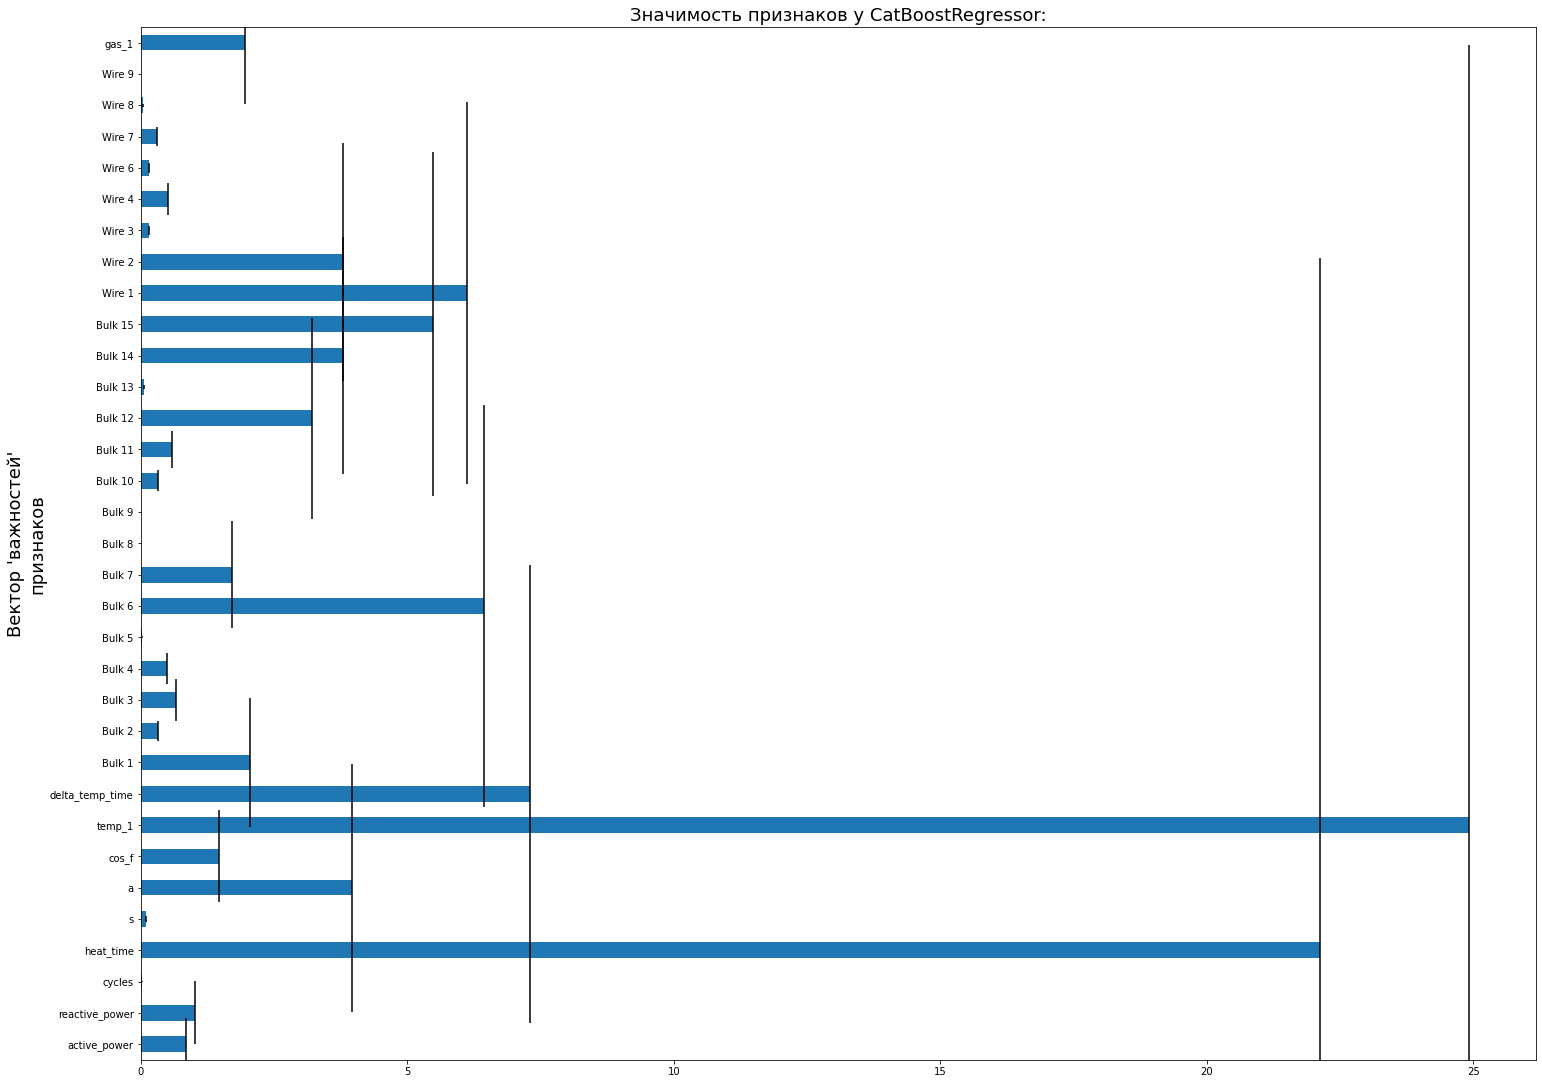

In [220]:
# вывод важности признаков для модели CatBoostRegressor:

get_importances(cat_model_importances, features_train, "CatBoostRegressor")

### Выводы

[Назад к содержанию](#Содержание)

Как видно из графика важности признаков, наиболее важны следующие параметры:

   - первичная температура нагрева;
   - время нагрева;
   - время между замерами температур;
   - сыпучие и проволочные добавки: Bulk 6, Wire 1 и Bulk 15. 
   
Данные парметры сильнее всего влияют на конечную температуру сплава. Заказчику необходимо обратить на эти параметры особое внимание.


### Вывод

[Назад к содержанию](#Содержание)

Целью настоящего проекта была разработка модели машинного обучения, которая предскажет оптимальную температуру нагрева стали для металлургического комбината ООО «Так закаляем сталь». Комбинат поставил задачу - экономить на электропотреблении на этапе обработки стали.

В настоящем проекте не моделировалось электропотребление, а предсказывалась финальная температура сплава. Как выяснилось в ходе разработки проекта конечная температура тесно связана с первичной, временем нагрева и некоторыми добавляемыми материалами. 

Предсказание конечной температуры влияет косвенно на электропотребление и, соответственно, экономию. Помимо энергозатрат предсказание конечной температуры сплава влияет также на ряд более значимых факторов в производстве:

   - срок службы оборудования;
   - простои в случае ремонта оборудования;
   - частичная или полная замена вышедшего из строя оборудования.
   
Простои, время, потраченное на ремонт и стоимость технологического оборудования в конечном итоге для комбината будет стоить гораздо дороже потраченных мегаватт электроэнергии. В связи с этим важно понимать конечную температуру сплава, предсказывать ее по начальной температуре и ряду факторов: объем засыпанных сыпучих и проволочных материалов.

В качестве исходных данных было предоставлено заказчиком 7 датасетов, кадый из которых необходимо было проанализировать на предмет корретных данных, выявить отсутствие данных и аномальные значения. В конечном итоге необходимые данные для обучения моделей были объединены в один датафрейм, который в последствии использовался для обучения и тестирования модели.

В ходе анализа исходных данных было выявлено достаточно большое количество отсутствующих данных по измерению температуры и нагреву. Т.к. определение конечной температуры является целевым признаком, то в случае отсутствия замера по партии эта партия была исключена из моделирования. Таким же образом поступили с данными а нагреве сплава.

В процесе агрегирования данных в итоговый датафрейм было исключено много партий. Это сказалось на обучении, т.к. поставленной метрики качества модели - МАЕ не более 6.8 - было не просто добиться. Для достижения поставленной метрики были синтезированы некоторые признаки, например, работа, мощность, косинус фи, время нагрева, количество итераций в партии и т.п. 

Были обучены следующие модели: LGBMRegressor, CatBoostRegressor, XGBRegressor, Линейная регрессия, RandomForestRegressor и Ridge. Лучше всех справилась модель, обученная с помощью `CatBoostRegressor`. Оптимальные параметры модели подбирались с помощью RandomizedSearchCV. 

Модель обучалась на исходных данных. Выбросы практически не были удалены, поскольку возможно это не были выбросы, а реальные параметры, что хорошо бы уточнить у технолога. В данных были исключены партии, замер температур которых был менее 1500 градусам, поскольку была предоставлена информация заказчиком о том, что температура плавления выпускаемой стали не может быть менее 1500 градусам. Также была выявлена партия с аномально-отрицательной реактивной мощностью, которая не может быть в настоящем производстве. Такие партии были исключены из обучения моделей. Также были исключены партии с отсутствующими данными по первичной или конечной температуре.

Модель достигла требуемого качества (МАЕ на тестовой выборке составляет 6.002). Тем не менее, входе анализа пришли к выводу, что данных не хватает, что может сказаться в продакшн. В качестве рекомендации комбинату можно посоветовать и далее накапливать информацию по процессу производства сплава и при достаточном количестве данных, например через год, можно будет дообучить модель, что еще лучше скажется на качестве предсказания. Возможно в будущем модель сможет выполнять функцию предиктивной аналитики и предсказывать время поломки оборудования или простоя, т.к. в исходных данных за полгода были 4 дня останова производства.

Заказчику стоит обратить внимание на первичную температуру стали, время нагрева, время между нагревом и такие добавки как Bulk 6, Wire 1 и Bulk 15, т.к. это основной фактор влияния на конечную температуру. Возможно стоит автоматизировать процесс отслеживания критически-высоких температур с выдачей предупредительной или аварийной информации технологам и обслуживающему персоналу. Поскольку от этого напрямую зависит финансовое благополучие комбината. 

## Отчет

### Сравнение решения и плана

[Назад к содержанию](#Содержание)

План работы включал следующие основные пункты:

   1. Обработка данных:
      
      - обработка пропусков;
      - приведение наименования признаков на английский язык;
      - проверка наличия партий с единичным замером температуры;
      - анализ данных о сыпучих и проволочных материалах (с объемом и временем), проверка данных на предмет корректности полученных данных;
      - замена реактивной и активной энергии на полную мощность, введение новых признаков, таких как время нагрева, время между замерами температур, работа, объем добавленных редких сыпучих и проволочных материалов, количествовведенных добавок.
      
   
   2. Объединение датафреймов:
   
      - объединение в финальный датафрейм датафреймов, необходимых для обучения моделей;
      - анализ финального датафрейма на предмет аномальных значений, выбросов и масштаба принимаемых значений;
      - исключение признаков с высокой долей корреляционной зависимости (для обучения модели с помощью линейной регрессии);
      - масштабирование признаков (для линейной регрессии).
      
   
   3. Обучение моделей:
   
      - подготовка обучающей и тестовой выборок;
      - разделение выборок на обучающую и тестовую в соотношении 90%:10%, соответственно;
      - обучение моделей с помощью LGBM, CatBoost, Ridge, а также с применением линейной регрессии, дерева решений в регрессии и случайного леса в регрессии;
      - выбор наилучшей модели;
      - сравнение наилучшей модели с константной;
      - тестирование наилучшей модели на тестовой выборке;
      - проверка достижения МАЕ на тестовой выборке не более 6.8;
      - исследование важности признаков наилучшей модели. 
      

В целом все основные пункты были выполнены.
      

### Описание трудностей проекта и их решение

[Назад к содержанию](#Содержание)

1. Понимание технологического процесса. Без технолога предстояло изучить 7 отдельных датасетов. Поскольку все датасеты были получены из разных источников, необходимо было погрузиться в анализ большого количества данных и понять корректность полученных данных. Данная работа была выполнена, данные были предоставлены корректные.

2. Достижение требуемой метрики МАЕ менее 6.8. Данная метрика на тестовой выборке была достигнута не сразу. С помощью введения новых признаков удалось добиться требуемого качества предсказания. Дополнительно были введены следующие признаки:

   - работа;
   - полная мощность;
   - косинус фи;
   - время нагрева;
   - количество итераций в партии;
   - время между замерами температур.
   
Какие-то признаки обладали высокой корреляционной зависимостью с другими признаками, поэтому для обучений с помощью линейной регрессии от некоторых признаков пришлось избавиться. Для обучения остальных моделей были задействованы все признаки. Обучение моделей проходило без признака с номером партии (key).

4. Достижение прохождения кода обучения всех моделей в течение не более 30 минут. Решил за счет подбора оптимальных параметров моделей и с помощью RandomizedSearchCV.

5. Недостаточное количество наблюдений и аномальные значения. В ходе предобработки данных было исключено из моделирования большое количество партий, что негативно сказалось на требуемом значении МАЕ. Требуемую точность удалось тостичь благодаря введению новых признаков.  

### Ключевые шаги решения

[Назад к содержанию](#Содержание)

Ключевые шаги решения следующие:

   - исследование и предобработка исходных данных;
   - удаление выбросов;
   - агрегирование финального датафрейма;
   - анализ финального датафрейма;
   - обучение моделей;
   - выбор наилучшей модели;
   - сравнение наилучшей модели с константной;
   - тестирование наилучшей модели.

In [223]:
features_train.head()

,active_power,reactive_power,cycles,heat_time,s,a,cos_f,temp_1,delta_temp_time,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,gas_1
889,3.197052,2.427976,5,637,4.015459,541.291536,0.795346,1568.0,2007,0.0,0.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.0,0.0,86.112000,74.55552,0.0,0.0,0.0,0.0,0.0,0.0,4.350301
1931,2.342584,1.918865,4,351,3.031654,288.304623,0.778950,1608.0,1858,0.0,0.0,131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,257.0,0.0,152.0,105.0,85.132317,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,12.011040
1060,3.668425,2.630622,5,1234,4.515547,949.380712,0.813964,1585.0,2266,0.0,0.0,0.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,411.0,0.0,241.0,204.0,109.184402,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,10.527412
615,2.263296,1.706028,3,427,2.835714,437.925923,0.802296,1608.0,918,0.0,0.0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,154.0,154.0,68.047203,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,18.474057
2246,1.688819,1.153021,3,607,2.045995,354.739080,0.830597,1569.0,1060,0.0,0.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.0,0.0,114.0,106.0,47.087040,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,5.444091


### Используемые признаки для обучения итоговой модели

[Назад к содержанию](#Содержание)

Для обучения и тестирования наилучшей модели **CatBoostRegressor** был использован финальный датафрейм размером 2324 х 37, в котором присутствуют следующие признаки: 

   1) первичный замер температуры сплава;
   
   2) время нагрева;
   
   3) время между замерами температур;
   
   4) данные о засыпке сыпучих материалов: Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 8, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15;
   
   5) данные о подаче проволочных материалов: Wire 1, Wire 2, Wire 3, Wire 4, Wire 6, Wire 7, Wire 8, Wire 9;
   
   6) количество добавленных проволочных материалов;
     
   7) данные о продуве газом;
   
   8) полная мощность;
   
   9) работа - добавленный признак, вычисленный как произведение полной мощности на потраченное время (полная мощность была также рассчитана как корень из сумм квадратов активной и реактивной мощности);
     
   10) cos_f - введенный признак, рассчитанный как отношение активной мощности к полной;
   
   11) активная мощность;
   
   12) реактивная мощность;
      
   13) количество итераций в партии.

В качестве целевого признака была использована конечная измеренная температура сплава в партии.

Далее приведено описание признаков и их предобработка.

1) Данные по замерам температур были предоставлены в отдельном датафрейме, в котором была предоставлена информация по всем произведенным замерам температуры каждой партии и по каждой итерации. Для обучения моделей был использован первичный замер температуры сплава. В качестве целевого признака - конечный замер. На этапе предобработки были удалены партии, в которых:

  - температура сплава была зафиксирована менее 1500 градусам по Цельсию;
  - отсутствовали замеры первичной или конечной температуры.
  
 Для агрегирования финального датафрейма были исключены все промежуточные замеры температур.

2) Время нагрева был введен как дополнительный признак и был рассчитан как разница по времени между стартом нагрева и остановом нагрева (в секундах).

3) Время между замерами температур также было введено как дополнительный признак и был рассчитан как разница по времени между замерами температур (в секундах).

4) Данные о подаче сыпучих материалов. Данные были предоставлены уже в агрегированном состоянии по каждой партии. Было обнаружено огромное количество отсутствующих данных. Пришли к выводу, что отсутствие данных означает отсутствие добавления материала в процессе производства. Заменили все отсутствующие значения нулем. При обучении использовали все 15 признаков: Bulk 1 - Bulk 15.

5) Количество введенных сыпучих материалов был введен как дополнительный признак и был рассчитан как количество раз добавленных всех сыпучих материалов в партии.

6) Объем добавленных редких сыпучих материалов. Данный признак был введен дополнительно. На этапе предобработки данных были обнаружены редко-добавляемые материалы. Т.е. в исходном датасете с данными о сыпучих материалах по таким материалам в большинстве случаев отсутствовала информация. Чтобы наиболее эффективно использовать информацию о таких материалах был введен новый признак - объем добавленных редких сыпучих материалов по каждой партии. Редкие сыпучие материалы определили по общей информации в датасете с сыпучими материалами. 

7) Данные о подаче проволочных материалов. Данные были предоставлены уже в агрегированном состоянии по каждой партии. Было обнаружено огромное количество отсутствующих данных. Пришли к выводу, что отсутствие данных означает отсутствие добавления материала в процессе производства. Заменили все отсутствующие значения нулем. При обучении использовали 8 типов проволочных материалов: Wire 1, Wire 2, Wire 3, Wire 4, Wire 6, Wire 7, Wire 8, Wire 9. Не был использован Wire 5, т.к. его добавили в процессе производства всего один раз и было принято решение удалить этот признак.

8) Количество добавленных проволочных материалов был введен как дополнительный признак и был рассчитан как количество раз добавленных всех проволочных материалов в партии.

9) Объем добавленных редких проволочных материалов. Данный признак был введен дополнительно. На этапе предобработки данных были обнаружены редко-добавляемые проволочные материалы. Для наиболее эффективного использования информации о таких материалах был введен новый признак - объем добавленных редких проволочных материалов по каждой партии. Редкие проволочные материалы определили по общей информации в датасете с проволочными материалами.

10) Данные о продуве газом были использованы полностью.

11) Полная мощность была введена в качестве дополнительного признака. Полная мощность была рассчитана как корень из сумм квадратов активной и реактивной мощности по каждой партии. 

12) Работа. Данный признак был введен дополнительно как произведение полной мощности на затраченное время нагрева. 

13) Косинус фи был введен дополнительно и был рассчитан как отношение активной мощности к полной.

14) Активная мощность. Были использованы все предоставленные данные. Поскольку данные были предоставлены по каждой итерации в партии, на этапе предобработки данных агрегировали данные по партиям.

15) Реактивная мощность. Была обнаружена партия с отрицательной реактивной мощностью, что в нашем проекте быть не может. Поэтому данная партия была исключена из моделирования. За исключением партии с отрицательной реактивной мощностью были использованы все предоставленные данные.

16) Количество итераций в парти был введен в качестве дополнительного признака. В датасете об электродах была предоставлена информация по нагреву сплава по каждой итерации. На основе этих данных было подсчитано количество итераций в каждой партии.

### Полное описание итоговой модели

[Назад к содержанию](#Содержание)

В работе было проведено обучение нескольким моделей: LGBMRegressor, CatBoostRegressor, XGBRegressor, Линейная регрессия, RandomForestRegressor и Ridge.

Наилучшей моделью была выбрана модель, обученная с помощью **CatBoostRegressor**. Ниже предоставлены ее параметры:

In [224]:
# наилучшие параметры лучшей модели:

cat.best_params_

{'learning_rate': 0.1, 'l2_leaf_reg': 6, 'depth': 2}

RANDOM_STATE = 50623

**Итоговая метрика на тесте**

МАЕ на тестовой выборке получилась со значением:

In [222]:
mae

6.00227275441828

Значение удовлетворяет требованию, поставленному заказчиком - менее 6.8 на тестовой выборке. 

Поэтому модель может быть передана для внедрения.